# Notebook for Neural Computation Project
### Haixiang Xu hxu@caltech.edu

## Abstract

This project is intended to explore the relative impact of regularization on neural network models, with detailed comparison between regularization coefficient of L1 and L2 norms. At the same time, the ability of L1 and L2 norms in creating sparse weight matrix will be investigated and we will see that L1 norm indeed have more generalization power in terms of creating sparse weights. The dropout layer is also introduced and compared with the result of L2 regularization. 

Moreover, the effects of different network architectures (deep neural network v.s. shallow neural network) and different activation function are also included in the project. The visualization of network is appended in the end as part of the conclusion. 

In this project, I use Keras as front end and Tensorflow as backend. The dataset I use is Mnist dataset. Code and report are mixed in this notebook. 


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.utils import np_utils
from keras.regularizers import l1, l2, l1l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using Theano backend.


The shape of training and testing data:

In [4]:
num_classes = 10
(Xtr, ytr), (Xts, yts_0) = mnist.load_data()
print("Xtr shape ", Xtr.shape)
print("ytr shape ", ytr.shape)
print("Xts shape ", Xts.shape)
print("yts shape ", yts_0.shape)

('Xtr shape ', (60000, 28, 28))
('ytr shape ', (60000,))
('Xts shape ', (10000, 28, 28))
('yts shape ', (10000,))


Show first 9 data points:

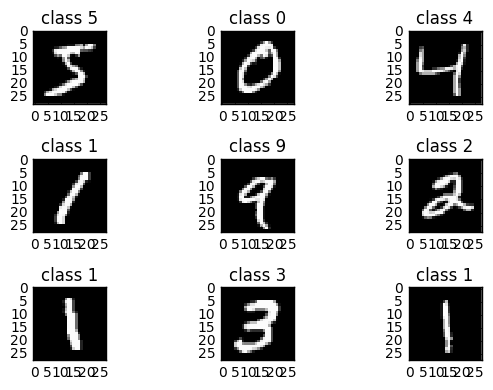

In [3]:
for i in xrange(9):
    plt.subplot(3,3,i+1)
    plt.imshow(Xtr[i], cmap='gray', interpolation='none')
    plt.title("class {}".format(ytr[i]))
plt.tight_layout()
plt.show()

Reshape training and testing data input, to a vector (for multi-layer perceptron)

In [5]:
Xtr = Xtr.reshape(len(Xtr), len(Xtr[0])*len(Xtr[0])).astype('float32') / 255.0
Xts = Xts.reshape(len(Xts), len(Xts[0])*len(Xts[0])).astype('float32') / 255.0

In [5]:
print("Xtr shape ", Xtr.shape)
print("Xts shape ", Xts.shape)

('Xtr shape ', (60000, 784))
('Xts shape ', (10000, 784))


In [6]:
ytr = np_utils.to_categorical(ytr, num_classes)
yts = np_utils.to_categorical(yts_0, num_classes)

## Build the network

In [7]:
def trainModel(Xtr, ytr, Xts, yts, 
    c_L1 = 0, c_L2 = 0, isDrop = False, layers = [256, 512, 256], act = 'relu'):
    "Init and train a model with L1 or L2 regularization"

    model = Sequential()
    model.add(Dense(layers[0], input_dim=len(Xtr[0]), W_regularizer=l1l2(l1=c_L1, l2=c_L2))) # elastic net regularization 
    # add the first hidden layer
    model.add(Activation(act))
    if (isDrop):
        model.add(Dropout(0.2)) # dropout rate 0.2
    for i in layers[1:-1]:
        model.add(Dense(i, W_regularizer=l1l2(l1=c_L1, l2=c_L2)))
        # add middle hidden layers
        model.add(Activation(act))
        if (isDrop):
            model.add(Dropout(0.2))
    model.add(Dense(10, W_regularizer=l1l2(l1=c_L1, l2=c_L2)))
    # add top output layer
    model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                     # ensures the output is a valid probaility distribution, that is
                                     # that its values are all non-negative and sum to 1.
    model.compile(loss='categorical_crossentropy', optimizer='adam') 
    # what is optimizer????????????? optional investigate
    chkpt = ModelCheckpoint(filepath="/tmp/cns187modelxhx.hdf5", monitor = 'val_loss', verbose = 0, 
                                    save_best_only = True, save_weights_only = False, mode = 'auto')
    es = EarlyStopping(monitor = 'loss', min_delta = 0.0001, patience = 2, verbose = 0, mode = 'auto')
    rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, verbose = 0, mode = 'auto', 
                            epsilon = 0.0001, cooldown=0, min_lr=0)
    callbacksList = [es, chkpt, rlr]
    history = model.fit(Xtr, ytr, batch_size=200, nb_epoch=200, show_accuracy=True, verbose=1,
              validation_split = 0.2, shuffle = True, callbacks = callbacksList) # max epoch = 200
    
    # evaluate performance with testing data
    score = model.evaluate(Xts, yts, show_accuracy = True, verbose = 0)
    print("score: ", score)
    
    predicted_class = model.predict_classes(Xts)
    compareMap = np.zeros((10,10)) # row: predicted class, col: real test class
    correctNum = 0.0
    for i in xrange(len(yts)):
        compareMap[predicted_class[i].astype(int), yts_0[i].astype(int)] += 1
        if (predicted_class[i].astype(int) == yts_0[i].astype(int)):
            correctNum += 1
    print(" \n")
    print("correct accuracy rate: ", correctNum/len(yts))
    print("error classified rate: ", 1-correctNum/len(yts))
    return history, model, compareMap.astype(int)
    

In [22]:
his0, model0, compareMap0 = trainModel(Xtr, ytr, Xts, yts, layers = [128, 128, 64, 64, 64, 64]) # no regularization at all

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 0.4446 - val_loss: 0.1837
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 0.1567 - val_loss: 0.1680
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 0.1111 - val_loss: 0.1278
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 0.0801 - val_loss: 0.1088
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 0.0623 - val_loss: 0.1120
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 0.0497 - val_loss: 0.0976
Epoch 7/200
48000/48000 [==============================] - 2s - loss: 0.0435 - val_loss: 0.1038
Epoch 8/200
48000/48000 [==============================] - 3s - loss: 0.0315 - val_loss: 0.1037
Epoch 9/200
48000/48000 [==============================] - 3s - loss: 0.0309 - val_loss: 0.1028
Epoch 10/200
48000/48000 [==============================] - 3s - loss: 0.0116 - val_lo

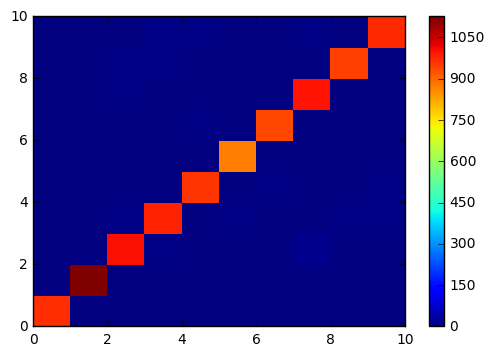

[[ 971    0    3    0    0    4    4    1    1    3]
 [   0 1126    1    0    1    0    2    1    0    3]
 [   2    2 1007    5    1    0    2   14    4    1]
 [   0    1    6  985    1    6    1    3    6    7]
 [   0    0    2    0  963    1    5    0    3    8]
 [   1    1    0    3    1  871    4    1    3    4]
 [   1    2    2    0    5    3  938    0    3    0]
 [   2    0    5    4    2    1    0 1002    2    4]
 [   2    3    6    8    2    3    2    0  950    4]
 [   1    0    0    5    6    3    0    6    2  975]]


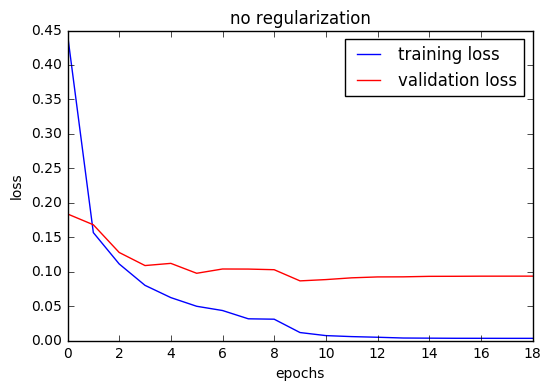

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


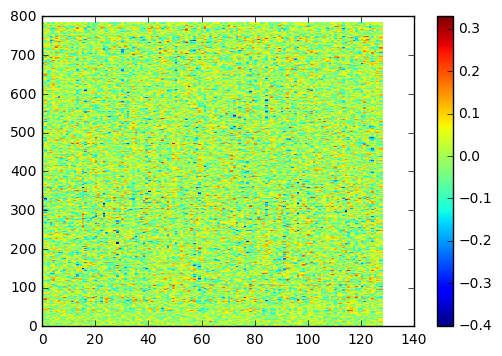

(784, 128)
('element portion close to zero: (<0.0001): ', 0.0011061065051020409)


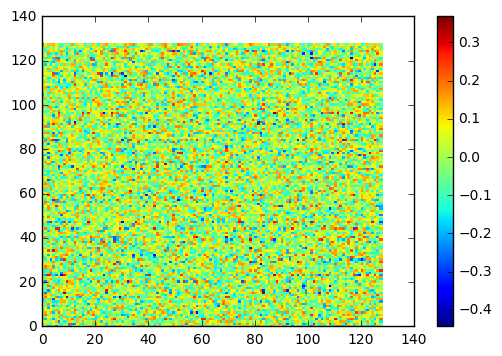

(128, 128)
('element portion close to zero: (<0.0001): ', 0.0006103515625)


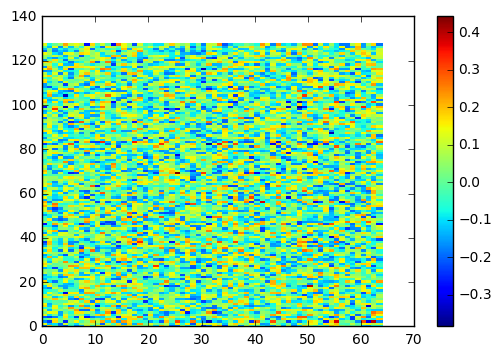

(128, 64)
('element portion close to zero: (<0.0001): ', 0.0006103515625)


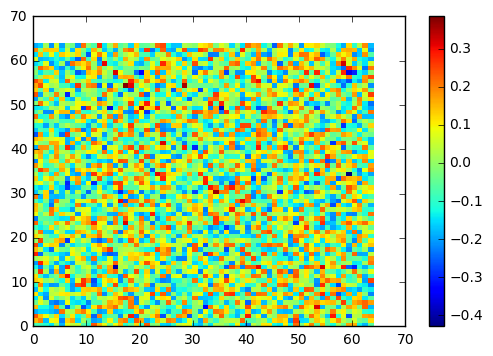

(64, 64)
('element portion close to zero: (<0.0001): ', 0.000732421875)


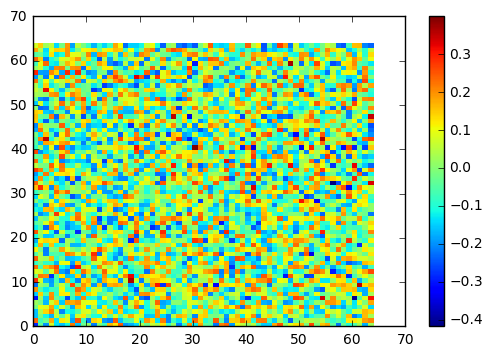

(64, 64)
('element portion close to zero: (<0.0001): ', 0.0)


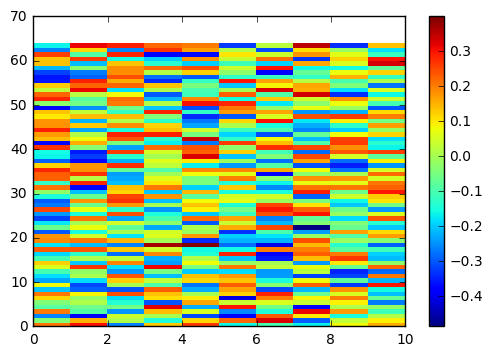

(64, 10)
('element portion close to zero: (<0.0001): ', 0.0)


In [41]:
plt.figure()
plt.pcolormesh(compareMap0)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap0
plt.figure()
plt.title("no regularization")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(np.array(his0.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(his0.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model0.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model0.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

## Regularization

### L2

In [44]:
print "L2 Regularization"
print "c = 1.0"
hisl2_1, modell2_1, compareMapl2_1 = trainModel(Xtr, ytr, Xts, yts, c_L2=1.0, layers = [128, 128, 64, 64, 64, 64])

plt.figure()
plt.pcolormesh(compareMapl2_1)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl2_1
plt.figure()
plt.title("L2, C = 1.0")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(0.2 * np.array(hisl2_1.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(hisl2_1.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell2_1.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell2_1.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.00001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

L2 Regularization
c = 1.0
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 105.1466 - val_loss: 2.3021
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 2.9584 - val_loss: 2.3019
Epoch 3/200
16400/48000 [=========>....................] - ETA: 1s - loss: 2.3102

KeyboardInterrupt: 

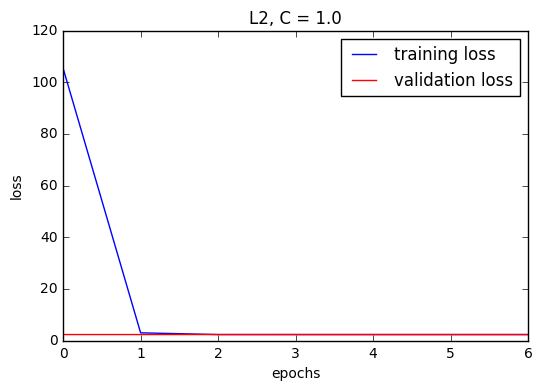

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


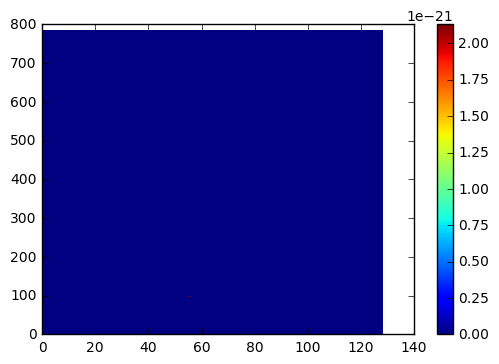

(784, 128)
('element portion close to zero: (<0.00001): ', 1.0)


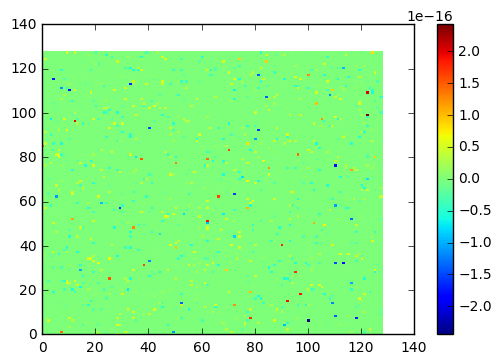

(128, 128)
('element portion close to zero: (<0.00001): ', 1.0)


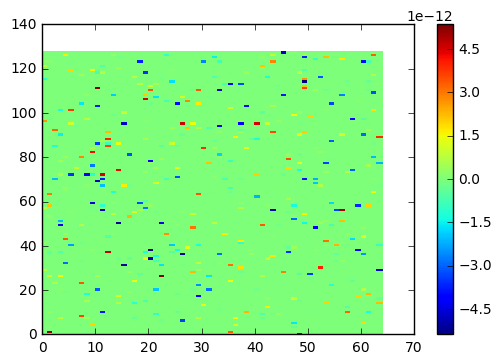

(128, 64)
('element portion close to zero: (<0.00001): ', 1.0)


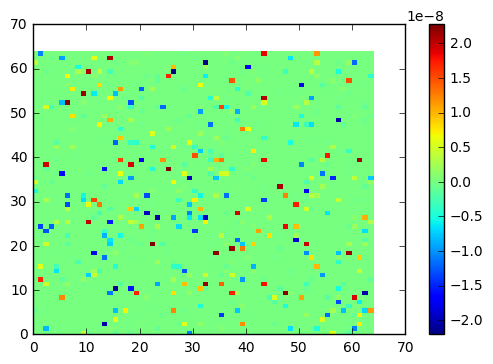

(64, 64)
('element portion close to zero: (<0.00001): ', 1.0)


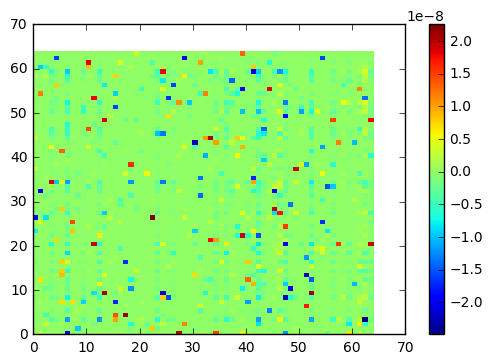

(64, 64)
('element portion close to zero: (<0.00001): ', 1.0)


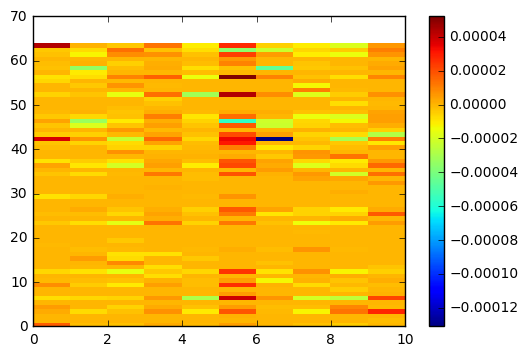

(64, 10)
('element portion close to zero: (<0.00001): ', 1.0)


In [45]:
plt.figure()
plt.title("L2, C = 1.0")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(np.array(hisl2_1.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(hisl2_1.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell2_1.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell2_1.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if ele < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.00001): ", zero_cnt/(r*c))

In [33]:
print "L2 Regularization"
print "c = 0.1"
hisl2_01, modell2_01, compareMapl2_01 = trainModel(Xtr, ytr, Xts, yts, c_L2=0.1, layers = [128, 128, 64, 64, 64, 64])

L2 Regularization
c = 0.1
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 12.5646 - val_loss: 2.3019
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 2.3667 - val_loss: 2.3020
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 2.3014 - val_loss: 2.3020
Epoch 4/200
48000/48000 [==============================] - 8s - loss: 2.3010 - val_loss: 2.3020
Epoch 5/200
48000/48000 [==============================] - 10s - loss: 2.3010 - val_loss: 2.3021
Epoch 6/200
48000/48000 [==============================] - 7s - loss: 2.3010 - val_loss: 2.3021
Epoch 7/200
48000/48000 [==============================] - 11s - loss: 2.3010 - val_loss: 2.3021
('score: ', 2.3009924800872801)
10000/10000 [==============================] - 2s     
 

('correct accuracy rate: ', 0.1135)
('error classified rate: ', 0.8865)


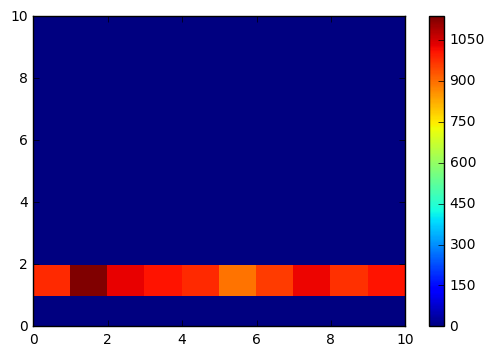

[[   0    0    0    0    0    0    0    0    0    0]
 [ 980 1135 1032 1010  982  892  958 1028  974 1009]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


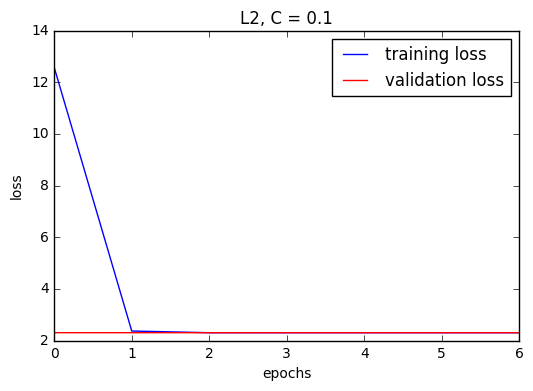

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


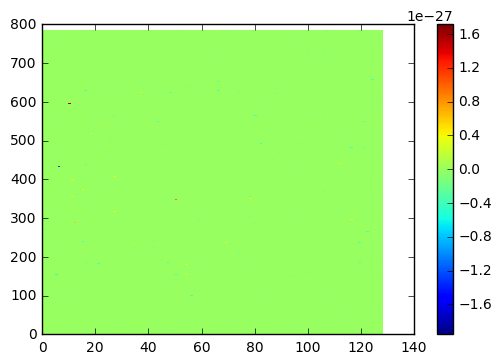

(784, 128)
('element portion close to zero: (<0.00001): ', 1.0)


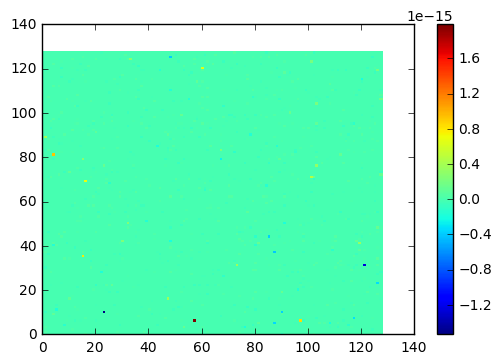

(128, 128)
('element portion close to zero: (<0.00001): ', 1.0)


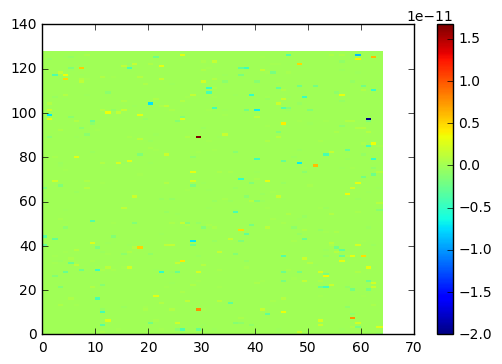

(128, 64)
('element portion close to zero: (<0.00001): ', 1.0)


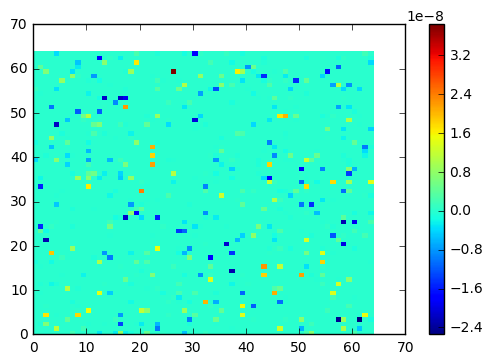

(64, 64)
('element portion close to zero: (<0.00001): ', 1.0)


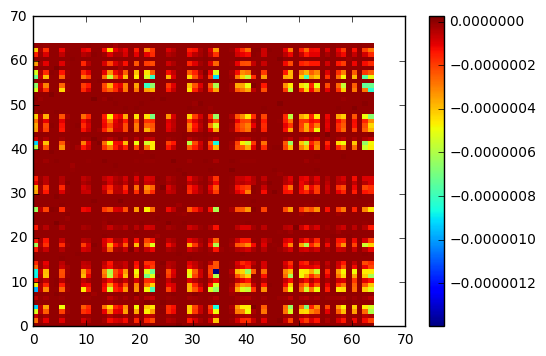

(64, 64)
('element portion close to zero: (<0.00001): ', 1.0)


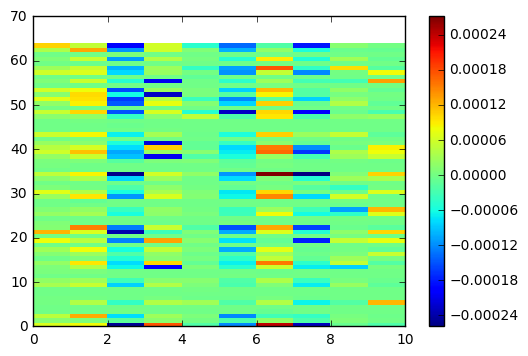

(64, 10)
('element portion close to zero: (<0.00001): ', 0.8890625)


In [46]:
plt.figure()
plt.pcolormesh(compareMapl2_01)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl2_01

plt.figure()
plt.title("L2, C = 0.1")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(np.array(hisl2_01.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(hisl2_01.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell2_01.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell2_01.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.00001): ", zero_cnt/(r*c))

In [36]:
print "L2 Regularization"
print "c = 0.01"
hisl2_001, modell2_001, compareMapl2_001 = trainModel(Xtr, ytr, Xts, yts, c_L2=0.01, layers = [128, 128, 64, 64, 64, 64])

L2 Regularization
c = 0.01
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 2.5951 - val_loss: 0.3501
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 1.2111 - val_loss: 0.3130
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 1.0531 - val_loss: 0.2800
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 0.9877 - val_loss: 0.2824
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 0.9472 - val_loss: 0.2674
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 0.9172 - val_loss: 0.2653
Epoch 7/200
48000/48000 [==============================] - 4s - loss: 0.8935 - val_loss: 0.2570
Epoch 8/200
48000/48000 [==============================] - 6s - loss: 0.8826 - val_loss: 0.2500
Epoch 9/200
48000/48000 [==============================] - 8s - loss: 0.8724 - val_loss: 0.2607
Epoch 10/200
48000/48000 [==============================] -

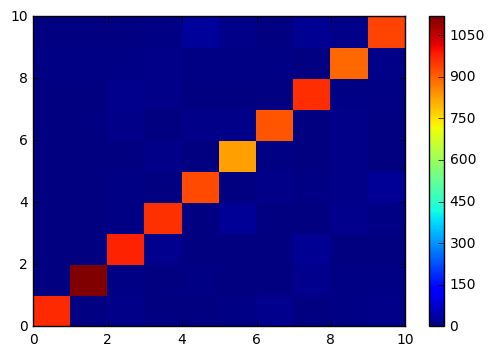

[[ 967    0    9    1    2    6   14    3    7   11]
 [   0 1117    5    1    5    1    3   17    5    8]
 [   1    1  975   14    1    1    1   18    4    0]
 [   0    3    5  956    0   23    0    2   14    7]
 [   0    0    5    0  928    2   10    7    9   24]
 [   3    1    0    9    0  828    8    0   13    3]
 [   3    3   10    0   12   11  916    0   11    1]
 [   1    1   15   10    2    0    0  962    6    7]
 [   5    8    8   13    5    7    6    0  892   12]
 [   0    1    0    6   27   13    0   19   13  936]]


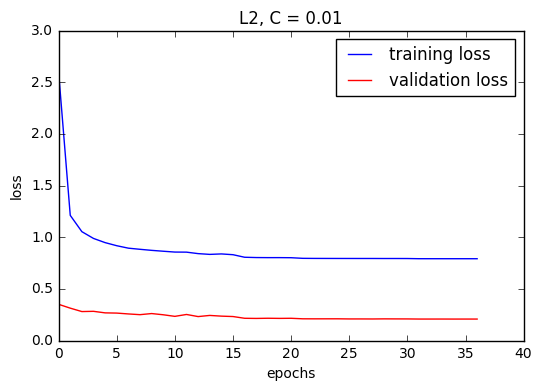

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


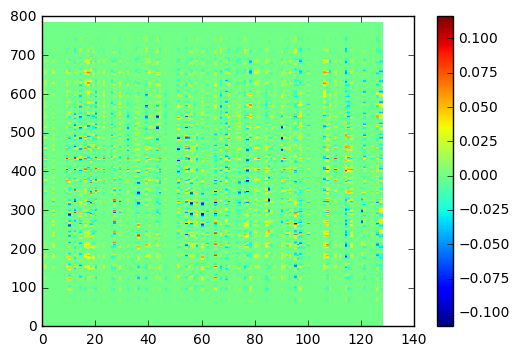

(784, 128)
('element portion close to zero: (<0.0001): ', 0.3937838807397959)


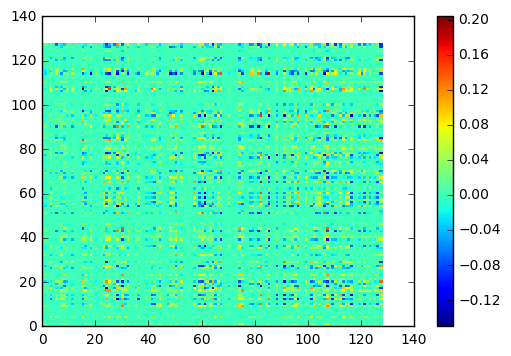

(128, 128)
('element portion close to zero: (<0.0001): ', 0.33941650390625)


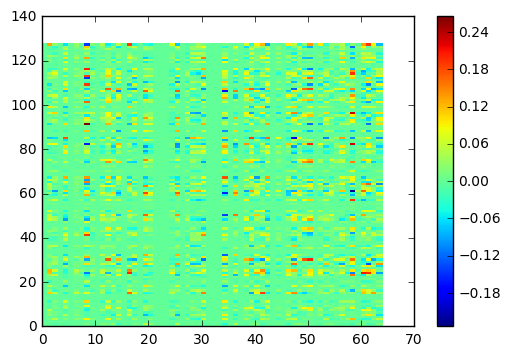

(128, 64)
('element portion close to zero: (<0.0001): ', 0.3846435546875)


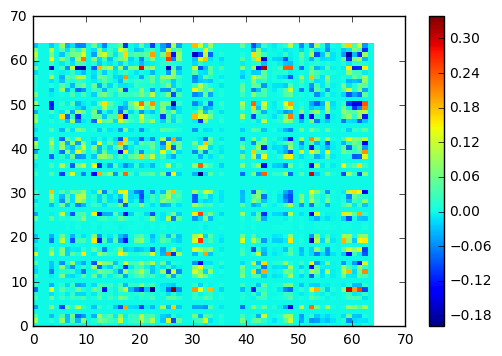

(64, 64)
('element portion close to zero: (<0.0001): ', 0.420166015625)


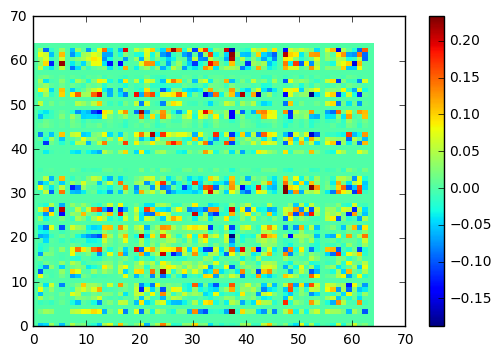

(64, 64)
('element portion close to zero: (<0.0001): ', 0.35888671875)


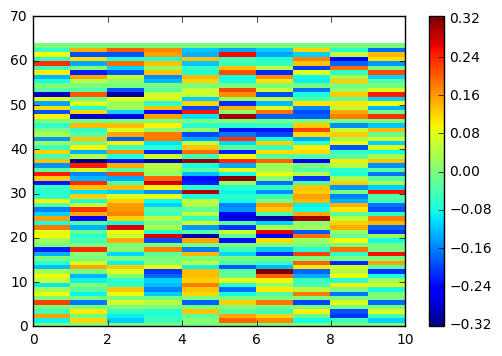

(64, 10)
('element portion close to zero: (<0.0001): ', 0.125)


In [48]:
plt.figure()
plt.pcolormesh(compareMapl2_001)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl2_001

plt.figure()
plt.title("L2, C = 0.01")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(np.array(hisl2_001.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(hisl2_001.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell2_001.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell2_001.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [38]:
print "L2 Regularization"
print "c = 0.001"
hisl2_0001, modell2_0001, compareMapl2_0001 = trainModel(Xtr, ytr, Xts, yts, c_L2=0.001, layers = [128, 128, 64, 64, 64, 64])

L2 Regularization
c = 0.001
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 3s - loss: 0.8570 - val_loss: 0.2030
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 0.4821 - val_loss: 0.1434
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 0.4072 - val_loss: 0.1374
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 0.3603 - val_loss: 0.1135
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 0.3272 - val_loss: 0.1056
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 0.3027 - val_loss: 0.1001
Epoch 7/200
48000/48000 [==============================] - 3s - loss: 0.2837 - val_loss: 0.0990
Epoch 8/200
48000/48000 [==============================] - 4s - loss: 0.2707 - val_loss: 0.1032
Epoch 9/200
48000/48000 [==============================] - 6s - loss: 0.2554 - val_loss: 0.0998
Epoch 10/200
48000/48000 [==============================] 

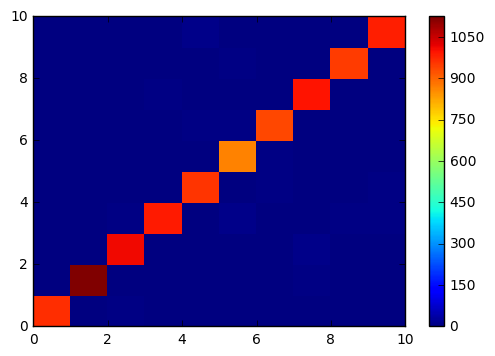

[[ 970    0    6    0    2    3    3    1    4    4]
 [   0 1125    1    0    0    0    3    6    0    2]
 [   2    4 1011    4    1    0    0   11    2    0]
 [   0    2    5  991    0    9    0    2    6    5]
 [   1    0    1    0  961    0    5    1    3    7]
 [   2    0    0    3    0  866    5    0    1    0]
 [   2    2    3    0    5    5  939    0    2    0]
 [   1    0    4    6    2    1    0 1001    2    4]
 [   2    2    1    3    0    6    3    2  951    0]
 [   0    0    0    3   11    2    0    4    3  987]]


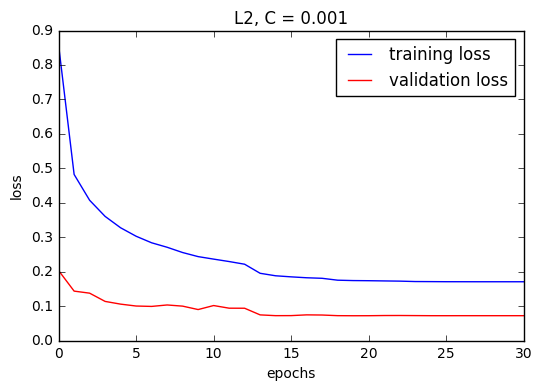

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


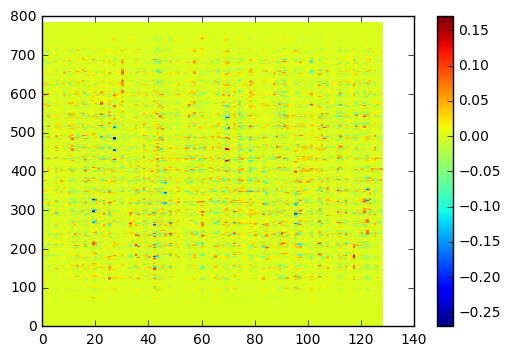

(784, 128)
('element portion close to zero: (<0.0001): ', 0.2330695950255102)


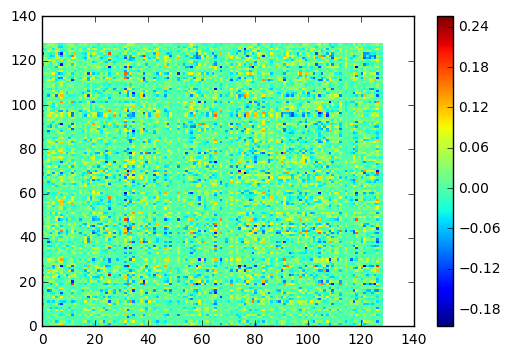

(128, 128)
('element portion close to zero: (<0.0001): ', 0.12451171875)


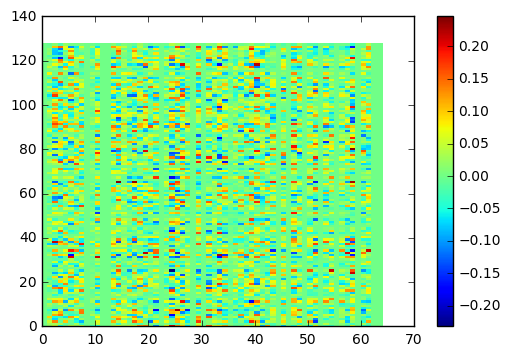

(128, 64)
('element portion close to zero: (<0.0001): ', 0.307373046875)


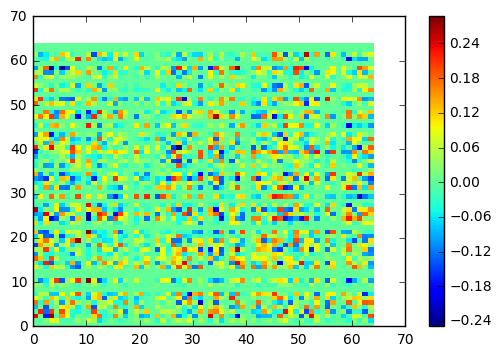

(64, 64)
('element portion close to zero: (<0.0001): ', 0.319091796875)


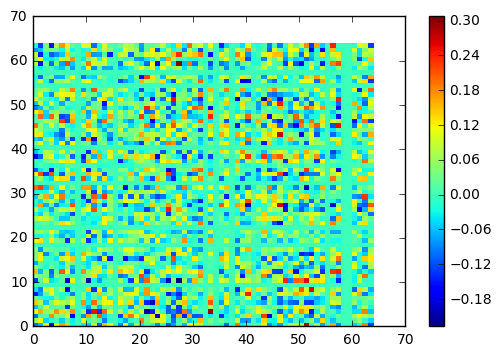

(64, 64)
('element portion close to zero: (<0.0001): ', 0.22119140625)


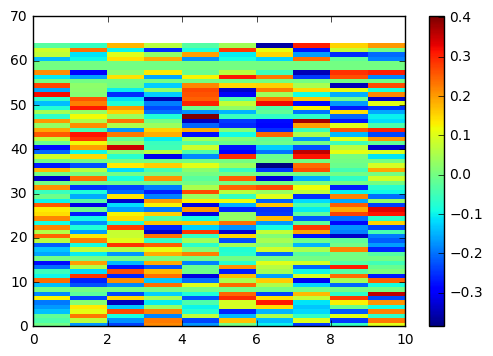

(64, 10)
('element portion close to zero: (<0.0001): ', 0.125)


In [49]:
plt.figure()
plt.pcolormesh(compareMapl2_0001)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl2_0001

plt.figure()
plt.title("L2, C = 0.001")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(np.array(hisl2_0001.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(hisl2_0001.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell2_0001.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell2_0001.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

L2 Regularization
c = 0.0001
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 0.5225 - val_loss: 0.1812
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 0.2079 - val_loss: 0.1432
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 0.1610 - val_loss: 0.1162
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 0.1340 - val_loss: 0.1081
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 0.1152 - val_loss: 0.0988
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 0.1071 - val_loss: 0.1046
Epoch 7/200
48000/48000 [==============================] - 5s - loss: 0.0970 - val_loss: 0.1141
Epoch 8/200
48000/48000 [==============================] - 4s - loss: 0.0923 - val_loss: 0.1058
Epoch 9/200
48000/48000 [==============================] - 4s - loss: 0.0692 - val_loss: 0.0814
Epoch 10/200
48000/48000 [==============================]

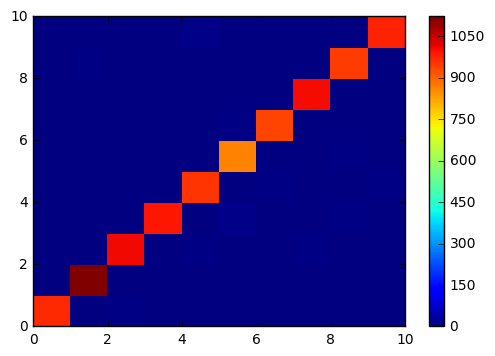

[[ 972    0    5    1    0    2    4    1    3    3]
 [   0 1122    1    0    1    0    3    3    0    4]
 [   1    3 1012    2    7    0    1    6    3    0]
 [   1    2    3  993    0   12    1    2    5    4]
 [   1    0    1    0  959    0    5    1    1    7]
 [   0    0    0    4    0  864    4    0    5    3]
 [   2    1    2    0    1    5  939    0    3    1]
 [   1    2    4    4    2    1    0 1008    3    4]
 [   2    5    4    4    2    4    1    4  949    4]
 [   0    0    0    2   10    4    0    3    2  979]]


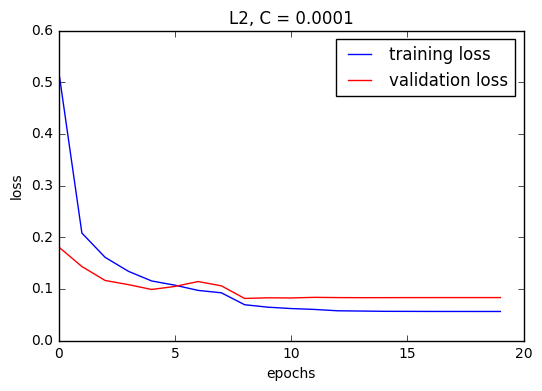

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


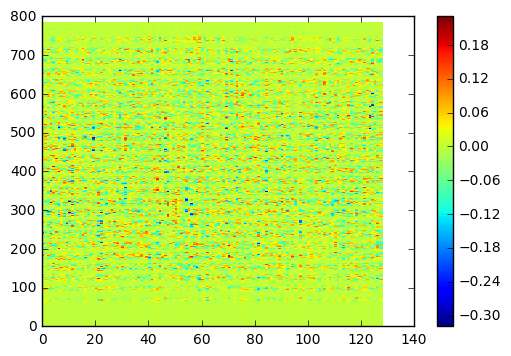

(784, 128)
('element portion close to zero: (<0.0001): ', 0.1966976243622449)


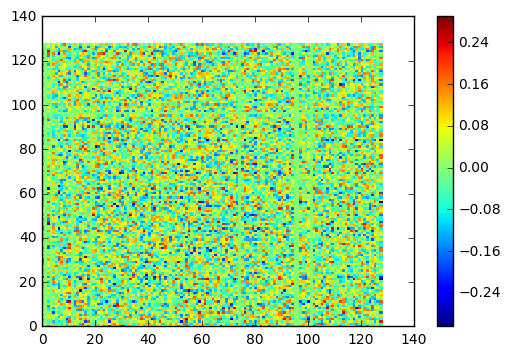

(128, 128)
('element portion close to zero: (<0.0001): ', 0.06427001953125)


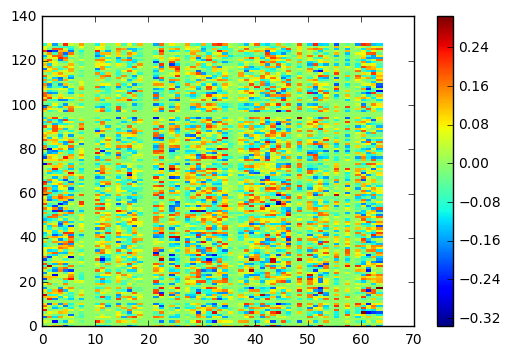

(128, 64)
('element portion close to zero: (<0.0001): ', 0.18115234375)


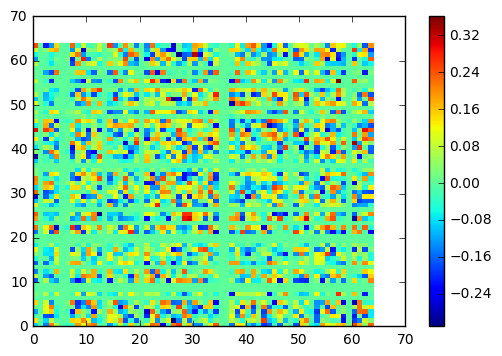

(64, 64)
('element portion close to zero: (<0.0001): ', 0.214599609375)


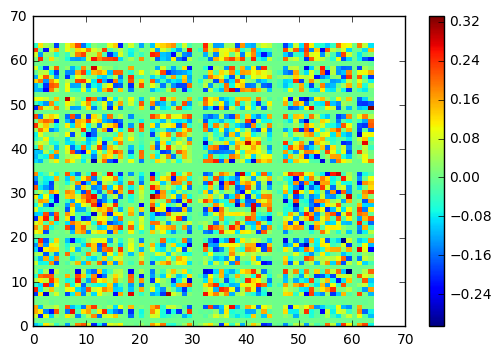

(64, 64)
('element portion close to zero: (<0.0001): ', 0.1884765625)


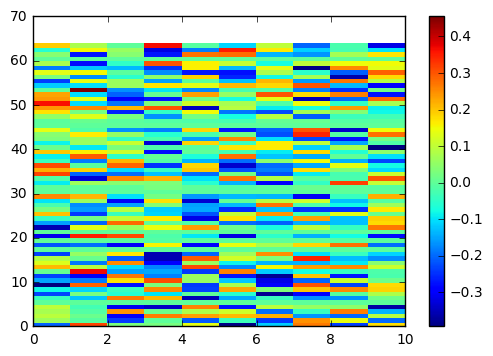

(64, 10)
('element portion close to zero: (<0.0001): ', 0.0921875)


In [63]:
print "L2 Regularization"
print "c = 0.0001"
hisl2_00001, modell2_00001, compareMapl2_00001 = trainModel(Xtr, ytr, Xts, yts, c_L2=0.0001, layers = [128, 128, 64, 64, 64, 64])

plt.figure()
plt.pcolormesh(compareMapl2_00001)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl2_00001

plt.figure()
plt.title("L2, C = 0.0001")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(np.array(hisl2_00001.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(hisl2_00001.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell2_00001.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell2_00001.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

### L1
### Different C


In [50]:
print "L1 Regularization"
print "c = 1.0"
hisl1_1, modell1_1, compareMapl1_1 = trainModel(Xtr, ytr, Xts, yts, c_L1=1.0, layers = [128, 128, 64, 64, 64, 64])

L1 Regularization
c = 1.0
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 3s - loss: 1258.2183 - val_loss: 2.3019
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 19.2691 - val_loss: 2.3019
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 19.0719 - val_loss: 2.3021
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 19.0708 - val_loss: 2.3021
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 6.0635 - val_loss: 2.3021
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 5.5661 - val_loss: 2.3021
Epoch 7/200
48000/48000 [==============================] - 2s - loss: 3.0554 - val_loss: 2.3021
Epoch 8/200
48000/48000 [==============================] - 3s - loss: 2.9579 - val_loss: 2.3021
Epoch 9/200
48000/48000 [==============================] - 3s - loss: 2.4523 - val_loss: 2.3021
Epoch 10/200
48000/48000 [============================

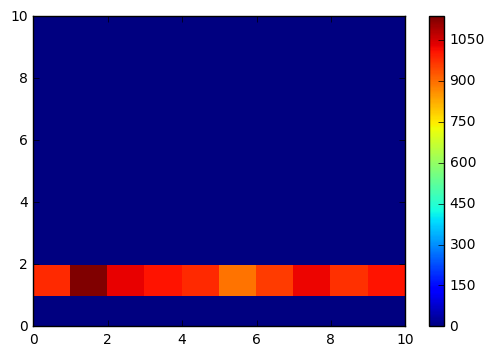

[[   0    0    0    0    0    0    0    0    0    0]
 [ 980 1135 1032 1010  982  892  958 1028  974 1009]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


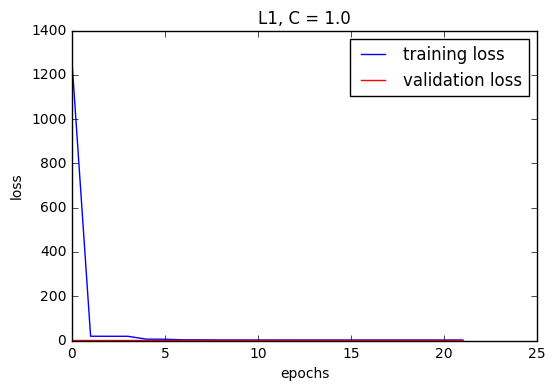

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


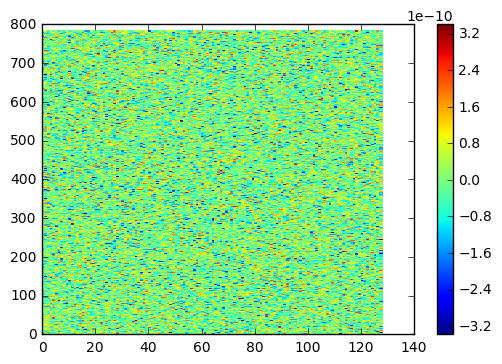

(784, 128)
('element portion close to zero: (<0.0001): ', 1.0)


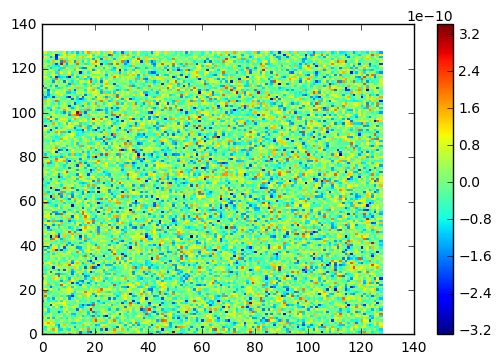

(128, 128)
('element portion close to zero: (<0.0001): ', 1.0)


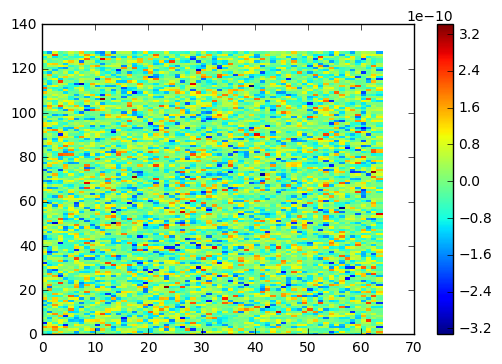

(128, 64)
('element portion close to zero: (<0.0001): ', 1.0)


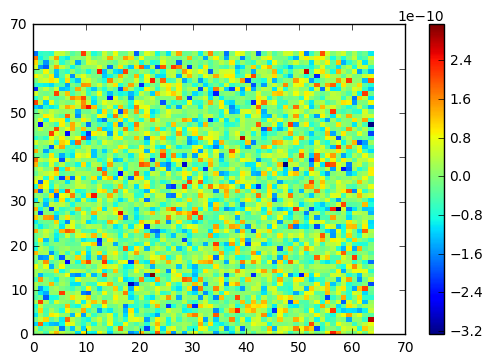

(64, 64)
('element portion close to zero: (<0.0001): ', 1.0)


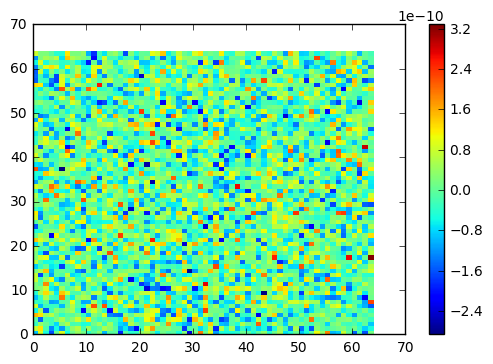

(64, 64)
('element portion close to zero: (<0.0001): ', 1.0)


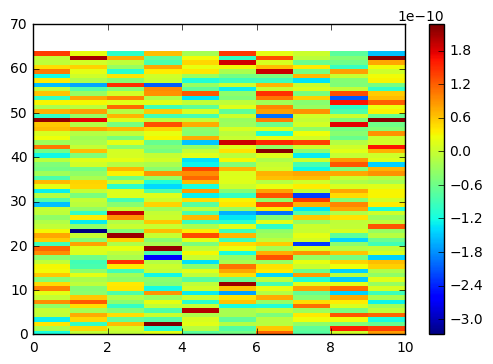

(64, 10)
('element portion close to zero: (<0.0001): ', 1.0)


In [51]:
plt.figure()
plt.pcolormesh(compareMapl1_1)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl1_1

plt.figure()
plt.title("L1, C = 1.0")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(np.array(hisl1_1.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(hisl1_1.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell1_1.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell1_1.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [52]:
print "L1 Regularization"
print "c = 0.1"
hisl1_01, modell1_01, compareMapl1_01 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.1, layers = [128, 128, 64, 64, 64, 64])

L1 Regularization
c = 0.1
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 127.4560 - val_loss: 2.3019
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 3.9929 - val_loss: 2.3020
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 3.9741 - val_loss: 2.3021
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 3.9740 - val_loss: 2.3021
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 2.6772 - val_loss: 2.3021
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 2.6274 - val_loss: 2.3021
Epoch 7/200
48000/48000 [==============================] - 2s - loss: 2.3765 - val_loss: 2.3021
Epoch 8/200
48000/48000 [==============================] - 2s - loss: 2.3668 - val_loss: 2.3021
Epoch 9/200
48000/48000 [==============================] - 2s - loss: 2.3161 - val_loss: 2.3021
Epoch 10/200
48000/48000 [==============================] 

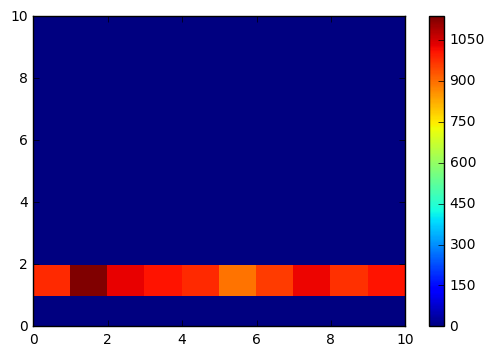

[[   0    0    0    0    0    0    0    0    0    0]
 [ 980 1135 1032 1010  982  892  958 1028  974 1009]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


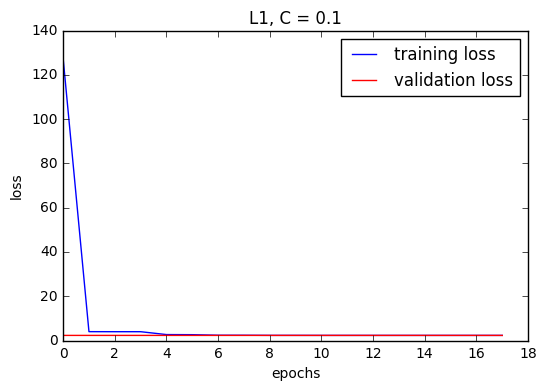

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


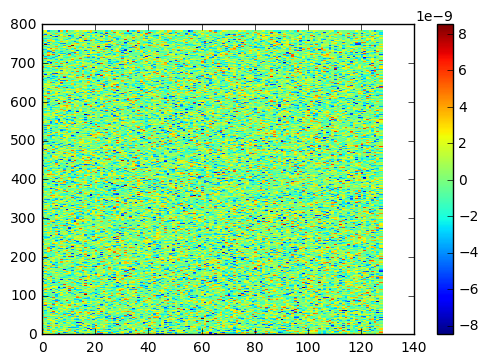

(784, 128)
('element portion close to zero: (<0.0001): ', 1.0)


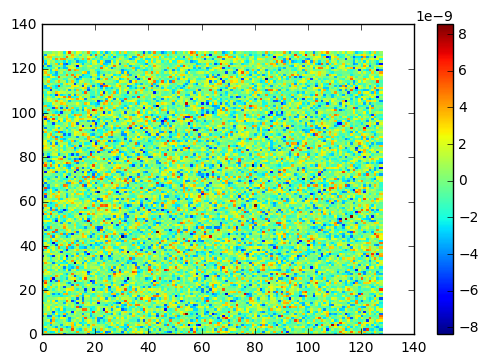

(128, 128)
('element portion close to zero: (<0.0001): ', 1.0)


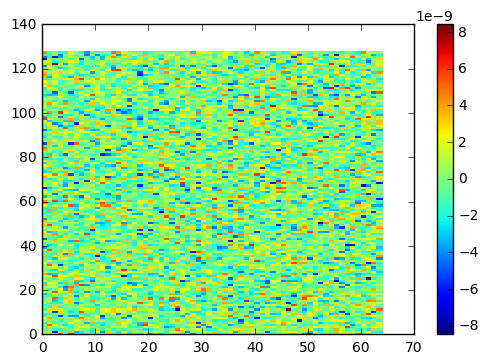

(128, 64)
('element portion close to zero: (<0.0001): ', 1.0)


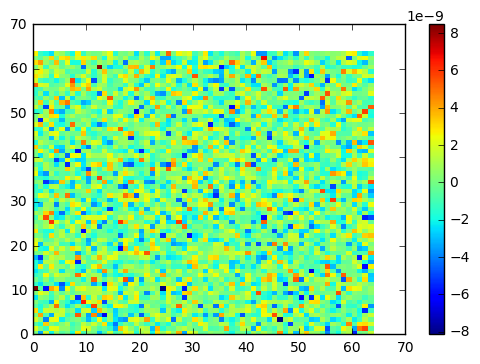

(64, 64)
('element portion close to zero: (<0.0001): ', 1.0)


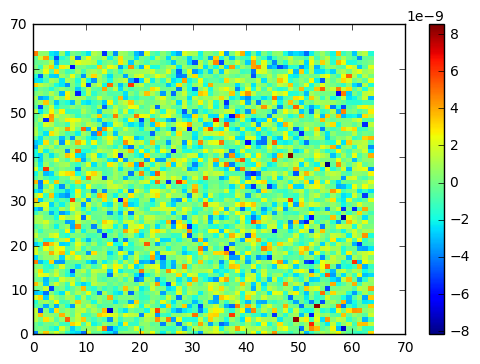

(64, 64)
('element portion close to zero: (<0.0001): ', 1.0)


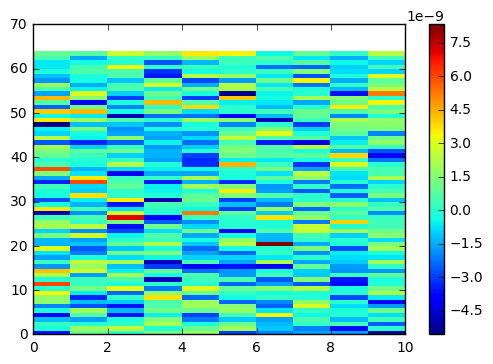

(64, 10)
('element portion close to zero: (<0.0001): ', 1.0)


In [53]:
plt.figure()
plt.pcolormesh(compareMapl1_01)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl1_01

plt.figure()
plt.title("L1, C = 0.1")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(np.array(hisl1_01.history['loss']), 'b-', label = 'training loss')
vls, = plt.plot(hisl1_01.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell1_01.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell1_01.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [54]:
print "L1 Regularization"
print "c = 0.01"
hisl1_001, modell1_001, compareMapl1_001 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.01, layers = [128, 128, 64, 64, 64, 64])

L1 Regularization
c = 0.01
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 14.8140 - val_loss: 2.3019
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 2.4694 - val_loss: 2.3021
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 2.4675 - val_loss: 2.3020
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 2.4675 - val_loss: 2.3021
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 2.3386 - val_loss: 2.3021
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 2.3337 - val_loss: 2.3021
Epoch 7/200
48000/48000 [==============================] - 2s - loss: 2.3085 - val_loss: 2.3021
Epoch 8/200
48000/48000 [==============================] - 2s - loss: 2.3075 - val_loss: 2.3021
Epoch 9/200
48000/48000 [==============================] - 2s - loss: 2.3025 - val_loss: 2.3021
Epoch 10/200
48000/48000 [==============================] 

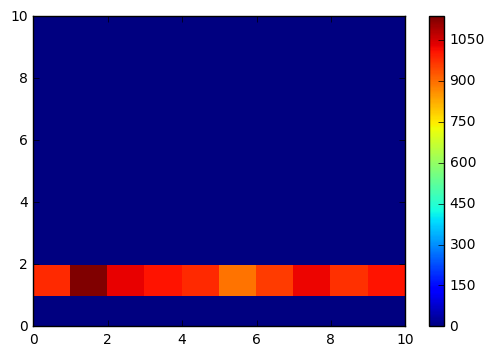

[[   0    0    0    0    0    0    0    0    0    0]
 [ 980 1135 1032 1010  982  892  958 1028  974 1009]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


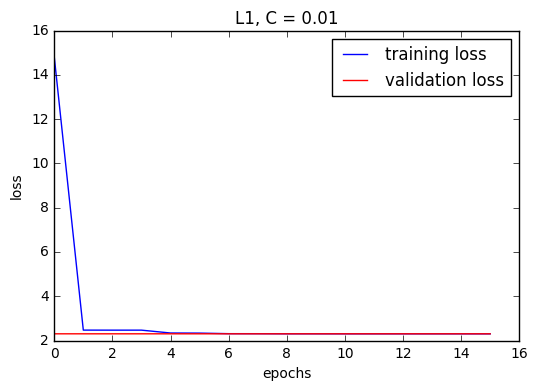

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


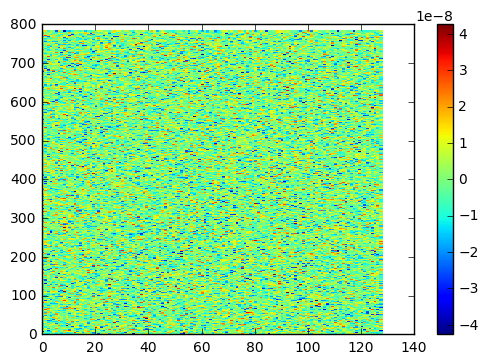

(784, 128)
('element portion close to zero: (<0.0001): ', 1.0)


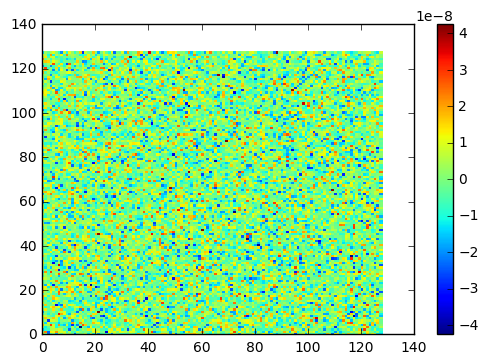

(128, 128)
('element portion close to zero: (<0.0001): ', 1.0)


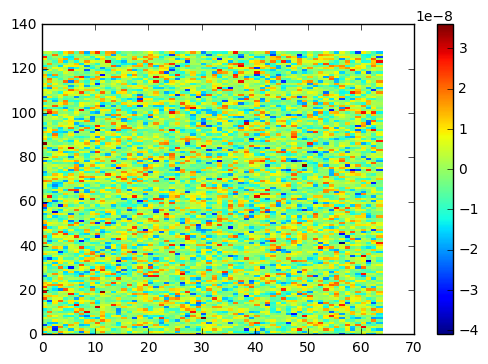

(128, 64)
('element portion close to zero: (<0.0001): ', 1.0)


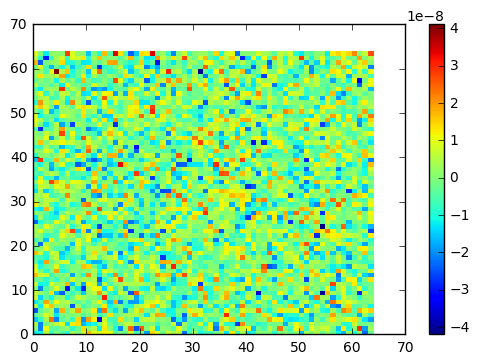

(64, 64)
('element portion close to zero: (<0.0001): ', 1.0)


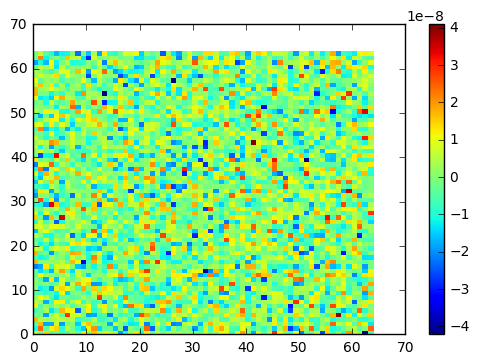

(64, 64)
('element portion close to zero: (<0.0001): ', 1.0)


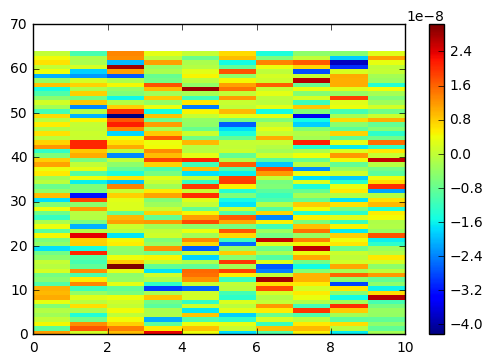

(64, 10)
('element portion close to zero: (<0.0001): ', 1.0)


In [55]:
plt.figure()
plt.pcolormesh(compareMapl1_001)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl1_001

plt.figure()
plt.title("L1, C = 0.01")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(hisl1_001.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(hisl1_001.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell1_001.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell1_001.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [56]:
print "L1 Regularization"
print "c = 0.001"
hisl1_0001, modell1_0001, compareMapl1_0001 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.001, layers = [128, 128, 64, 64, 64, 64])

L1 Regularization
c = 0.001
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 3.3256 - val_loss: 0.3646
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 1.6425 - val_loss: 0.3388
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 1.3429 - val_loss: 0.2958
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 1.1599 - val_loss: 0.2425
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 1.0372 - val_loss: 0.2551
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 0.9577 - val_loss: 0.2194
Epoch 7/200
48000/48000 [==============================] - 2s - loss: 0.8977 - val_loss: 0.2052
Epoch 8/200
48000/48000 [==============================] - 2s - loss: 0.8493 - val_loss: 0.1994
Epoch 9/200
48000/48000 [==============================] - 2s - loss: 0.8113 - val_loss: 0.2121
Epoch 10/200
48000/48000 [==============================] 

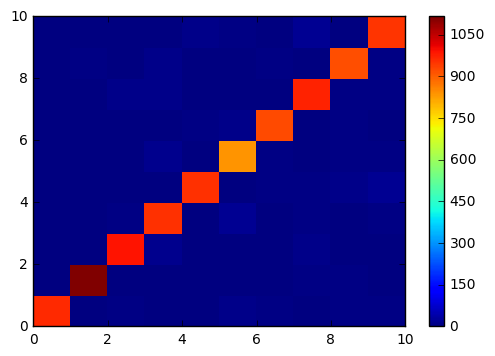

[[ 967    0    7    1    1    9    8    2    8    6]
 [   0 1116    4    1    0    0    3    7    5    3]
 [   4    1  991   15    2    0    2   11    3    0]
 [   0    4    6  955    0   20    0    7    4    7]
 [   0    0    2    1  955    1    6    5    9   18]
 [   1    1    1   14    0  838    7    0    8    6]
 [   3    3    4    0    7   11  926    0    5    0]
 [   2    2   13   11    2    3    0  974    8    8]
 [   3    8    4   10    4    3    6    4  921    7]
 [   0    0    0    2   11    7    0   18    3  954]]


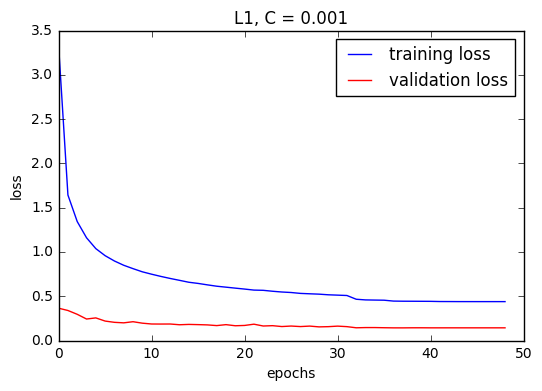

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


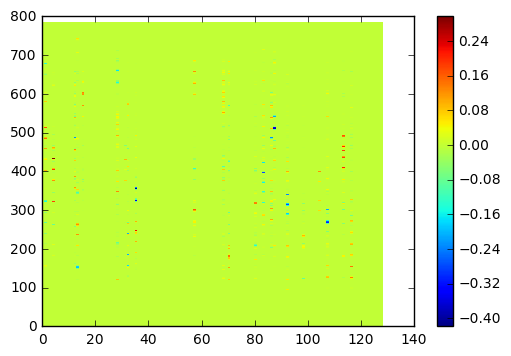

(784, 128)
('element portion close to zero: (<0.0001): ', 0.9638671875)


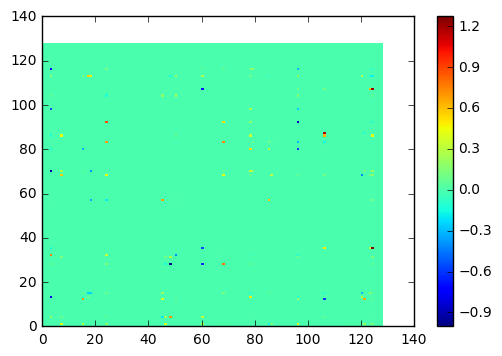

(128, 128)
('element portion close to zero: (<0.0001): ', 0.9876708984375)


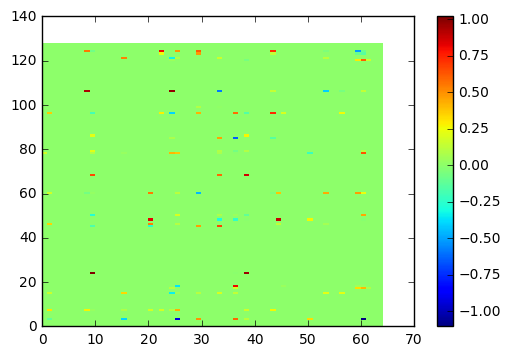

(128, 64)
('element portion close to zero: (<0.0001): ', 0.9813232421875)


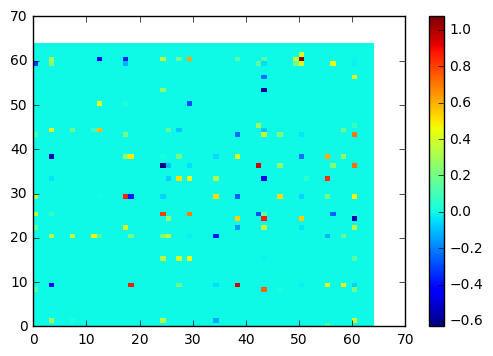

(64, 64)
('element portion close to zero: (<0.0001): ', 0.96435546875)


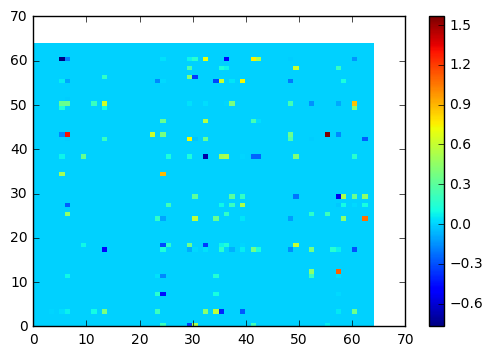

(64, 64)
('element portion close to zero: (<0.0001): ', 0.954345703125)


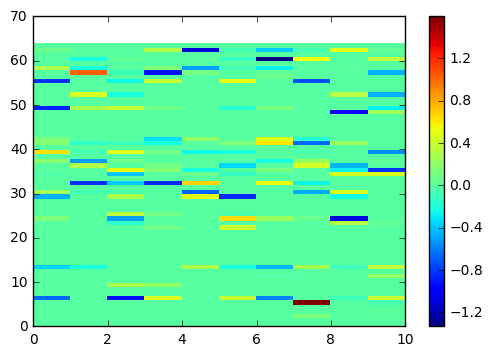

(64, 10)
('element portion close to zero: (<0.0001): ', 0.75)


In [57]:
plt.figure()
plt.pcolormesh(compareMapl1_0001)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl1_0001

plt.figure()
plt.title("L1, C = 0.001")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(hisl1_0001.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(hisl1_0001.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell1_0001.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell1_0001.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [58]:
print "L1 Regularization"
print "c = 0.0001"
hisl1_00001, modell1_00001, compareMapl1_00001 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [128, 128, 64, 64, 64, 64])

L1 Regularization
c = 0.0001
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 0.9265 - val_loss: 0.1902
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 0.5444 - val_loss: 0.1404
Epoch 3/200
48000/48000 [==============================] - 2s - loss: 0.4666 - val_loss: 0.1262
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 0.4186 - val_loss: 0.1163
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 0.3825 - val_loss: 0.1059
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 0.3555 - val_loss: 0.1021
Epoch 7/200
48000/48000 [==============================] - 2s - loss: 0.3403 - val_loss: 0.0991
Epoch 8/200
48000/48000 [==============================] - 2s - loss: 0.3200 - val_loss: 0.0980
Epoch 9/200
48000/48000 [==============================] - 2s - loss: 0.3039 - val_loss: 0.1042
Epoch 10/200
48000/48000 [==============================]

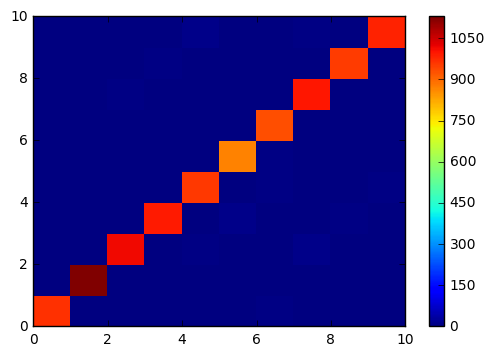

[[ 969    0    0    0    1    2    7    1    2    4]
 [   1 1129    0    0    0    0    3    3    0    2]
 [   2    0 1016    2    5    0    0   11    2    0]
 [   1    2    1  993    0   12    1    3    7    4]
 [   1    0    2    0  960    0    7    0    2    6]
 [   1    0    0    3    0  869    5    1    2    3]
 [   2    3    2    0    1    4  933    0    1    0]
 [   0    1    7    4    2    1    0 1000    3    4]
 [   2    0    4    5    0    2    2    2  953    2]
 [   1    0    0    3   13    2    0    7    2  984]]


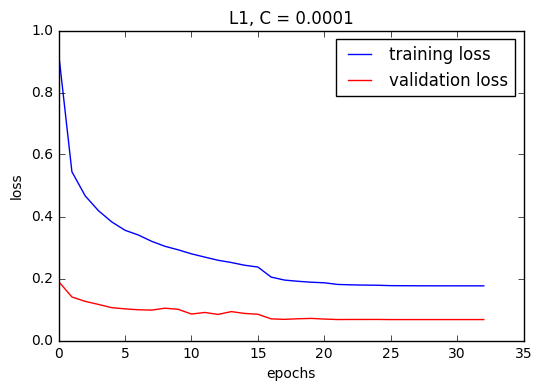

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


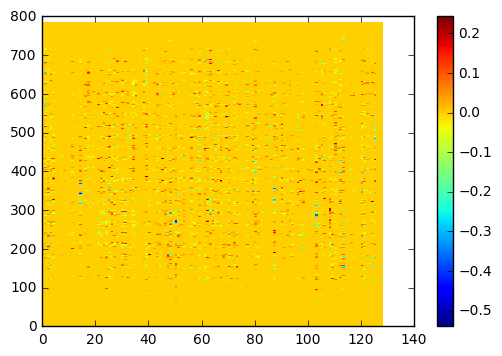

(784, 128)
('element portion close to zero: (<0.0001): ', 0.8246472417091837)


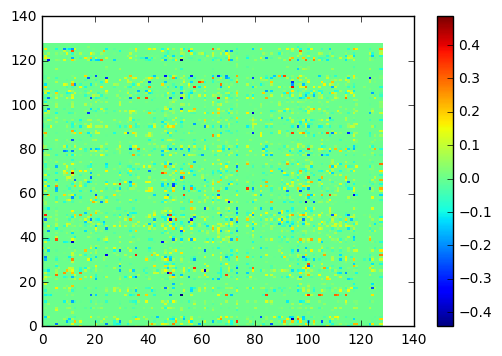

(128, 128)
('element portion close to zero: (<0.0001): ', 0.69952392578125)


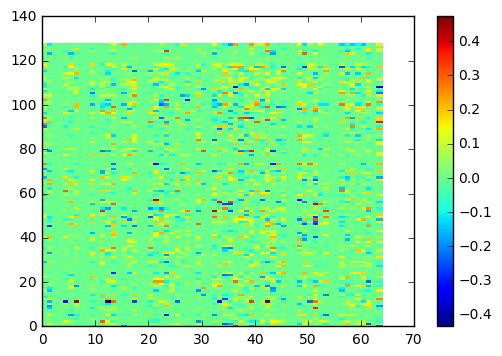

(128, 64)
('element portion close to zero: (<0.0001): ', 0.642578125)


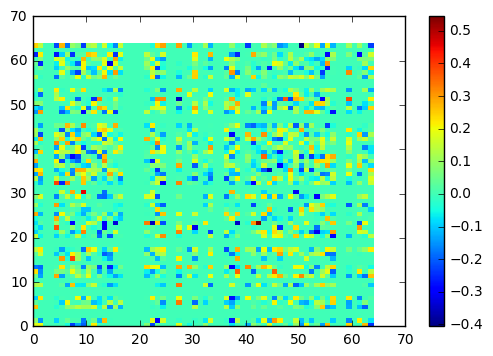

(64, 64)
('element portion close to zero: (<0.0001): ', 0.56591796875)


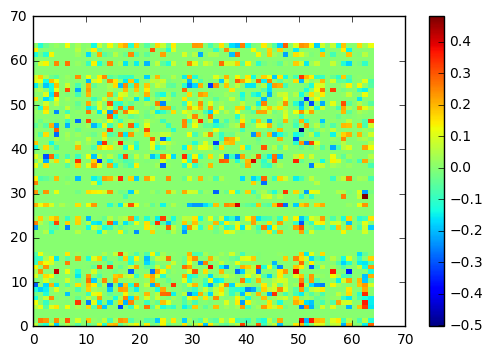

(64, 64)
('element portion close to zero: (<0.0001): ', 0.522216796875)


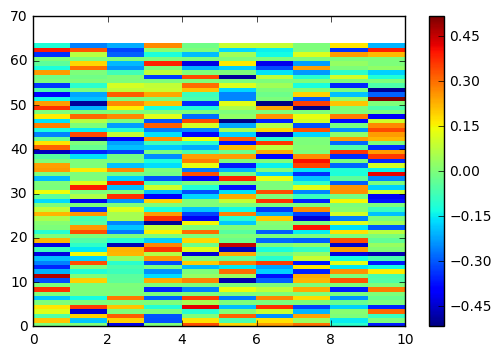

(64, 10)
('element portion close to zero: (<0.0001): ', 0.2)


In [59]:
plt.figure()
plt.pcolormesh(compareMapl1_00001)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapl1_00001

plt.figure()
plt.title("L1, C = 0.0001")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(hisl1_00001.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(hisl1_00001.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modell1_00001.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modell1_00001.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

### Dropout

L2 Regularization with dropout
c = 0.001
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 4s - loss: 1.2319 - val_loss: 0.2250
Epoch 2/200
48000/48000 [==============================] - 4s - loss: 0.6288 - val_loss: 0.1528
Epoch 3/200
48000/48000 [==============================] - 5s - loss: 0.5205 - val_loss: 0.1358
Epoch 4/200
48000/48000 [==============================] - 5s - loss: 0.4466 - val_loss: 0.1144
Epoch 5/200
48000/48000 [==============================] - 4s - loss: 0.4013 - val_loss: 0.1085
Epoch 6/200
48000/48000 [==============================] - 5s - loss: 0.3769 - val_loss: 0.1059
Epoch 7/200
48000/48000 [==============================] - 5s - loss: 0.3514 - val_loss: 0.1078
Epoch 8/200
48000/48000 [==============================] - 6s - loss: 0.3379 - val_loss: 0.1036
Epoch 9/200
48000/48000 [==============================] - 7s - loss: 0.3260 - val_loss: 0.1007
Epoch 10/200
48000/48000 [===================

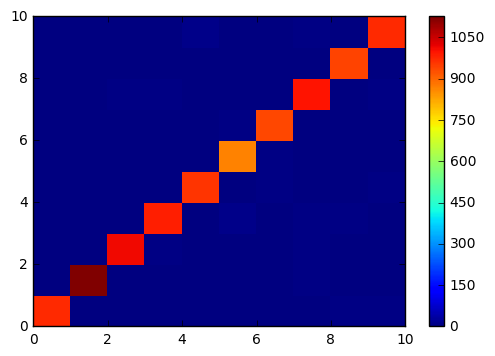

[[ 973    0    4    0    0    2    4    1    5    5]
 [   1 1126    2    0    0    0    3    8    1    3]
 [   1    2 1013    7    4    0    0    7    3    1]
 [   0    2    2  988    0    9    0    5    7    4]
 [   0    0    1    0  961    1    5    0    4    8]
 [   1    0    0    3    0  869    5    0    2    1]
 [   2    3    2    0    4    5  938    0    4    1]
 [   1    0    5    5    2    1    0  999    2    6]
 [   1    2    3    3    1    2    3    0  942    4]
 [   0    0    0    4   10    3    0    8    4  976]]


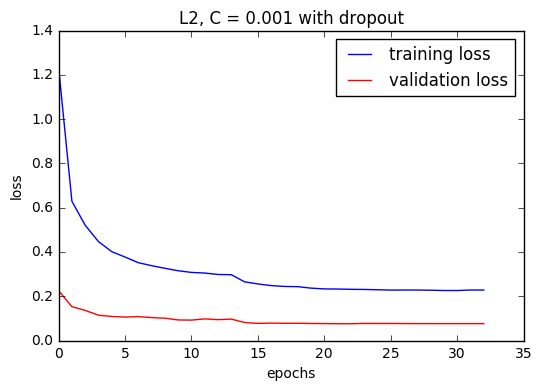

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


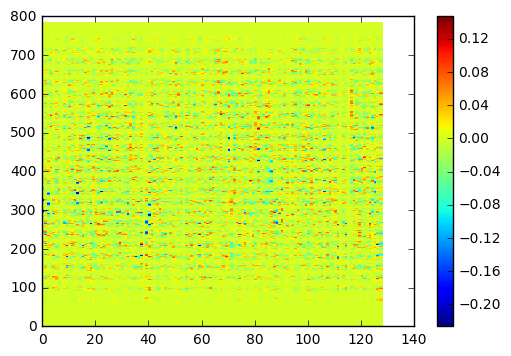

(784, 128)
('element portion close to zero: (<0.0001): ', 0.2552016900510204)


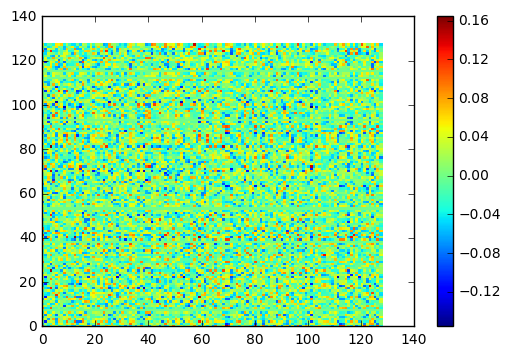

(128, 128)
('element portion close to zero: (<0.0001): ', 0.04840087890625)


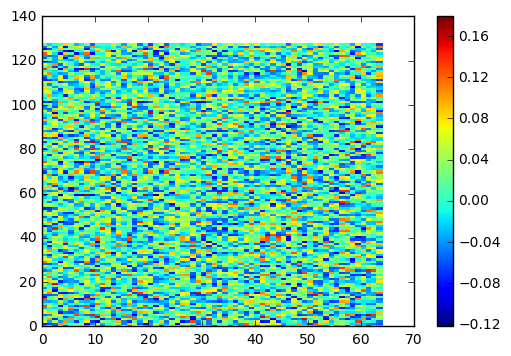

(128, 64)
('element portion close to zero: (<0.0001): ', 0.001708984375)


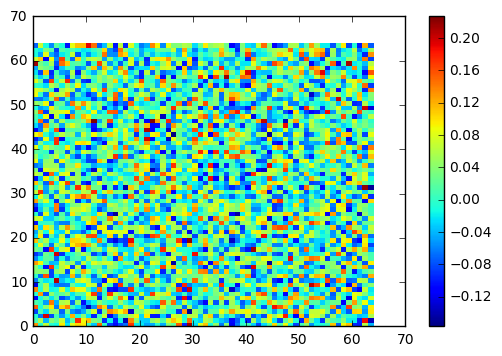

(64, 64)
('element portion close to zero: (<0.0001): ', 0.002197265625)


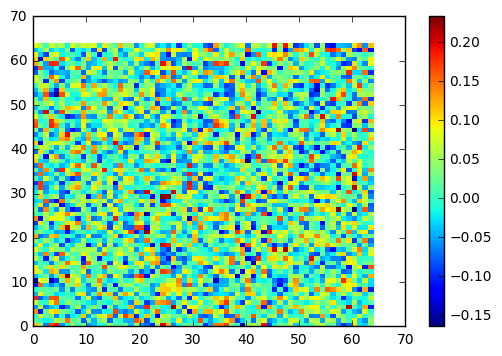

(64, 64)
('element portion close to zero: (<0.0001): ', 0.001220703125)


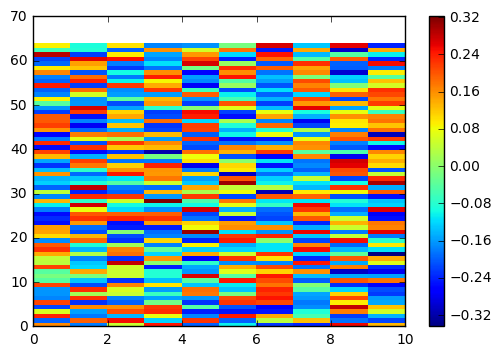

(64, 10)
('element portion close to zero: (<0.0001): ', 0.0)


In [62]:

#===
print "L2 Regularization with dropout"
print "c = 0.001"
hisd, modeld, compareMapd = trainModel(Xtr, ytr, Xts, yts, c_L2=0.001, isDrop = True, layers = [128, 128, 64, 64, 64, 64])
plt.figure()
plt.pcolormesh(compareMapd)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMapd

plt.figure()
plt.title("L2, C = 0.001 with dropout")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(hisd.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(hisd.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in modeld.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in modeld.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

## Neural Network Structure
### Deep
### Shallow
### plot of test error - structure

In [74]:
print "L1 , 512"
print "[512]"
his_s1, model_s1, compareMap_s1 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [512])

L1 , 512
[512]
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 5s - loss: 0.9866 - val_loss: 0.2182
Epoch 2/200
48000/48000 [==============================] - 4s - loss: 0.5075 - val_loss: 0.1726
Epoch 3/200
48000/48000 [==============================] - 4s - loss: 0.4008 - val_loss: 0.1527
Epoch 4/200
48000/48000 [==============================] - 4s - loss: 0.3533 - val_loss: 0.1394
Epoch 5/200
48000/48000 [==============================] - 4s - loss: 0.3244 - val_loss: 0.1256
Epoch 6/200
48000/48000 [==============================] - 4s - loss: 0.3010 - val_loss: 0.1122
Epoch 7/200
48000/48000 [==============================] - 4s - loss: 0.2835 - val_loss: 0.1031
Epoch 8/200
48000/48000 [==============================] - 4s - loss: 0.2683 - val_loss: 0.1071
Epoch 9/200
48000/48000 [==============================] - 4s - loss: 0.2559 - val_loss: 0.0965
Epoch 10/200
48000/48000 [==============================] - 4s - loss: 

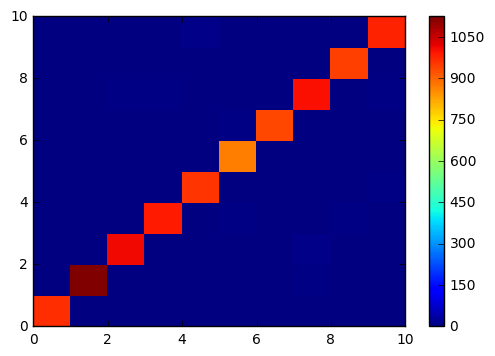

[[ 971    0    3    1    1    3    3    0    4    4]
 [   0 1125    1    0    0    0    4    7    0    3]
 [   1    3 1013    2    4    0    0   10    2    0]
 [   0    2    1  991    0    5    1    3    5    3]
 [   1    0    4    0  960    0    2    0    4    7]
 [   2    0    0    3    0  873    4    0    2    2]
 [   1    2    2    0    3    6  940    1    4    0]
 [   1    0    6    7    1    1    0 1003    3    5]
 [   3    3    2    4    2    2    4    1  946    1]
 [   0    0    0    2   11    2    0    3    4  984]]


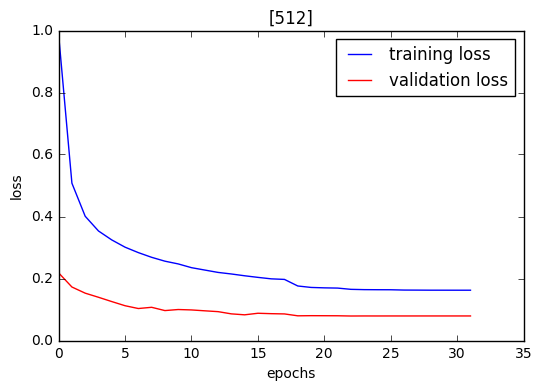

(784, 512)
(512,)
(512, 10)
(10,)


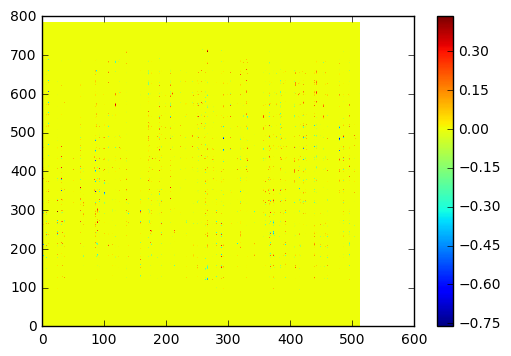

(784, 512)
('element portion close to zero: (<0.0001): ', 0.9577038823341837)


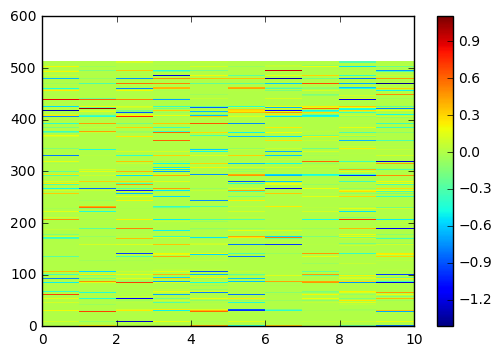

(512, 10)
('element portion close to zero: (<0.0001): ', 0.7525390625)


In [75]:
plt.figure()
plt.pcolormesh(compareMap_s1)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_s1

plt.figure()
plt.title("[512]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_s1.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_s1.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_s1.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_s1.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [77]:
print "L1 , 256, 256"
print "[256, 256]"
his_s2, model_s2, compareMap_s2 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [256, 256, 256])

L1 , 256, 256
[256, 256]
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 5s - loss: 1.0458 - val_loss: 0.1852
Epoch 2/200
48000/48000 [==============================] - 4s - loss: 0.6216 - val_loss: 0.1404
Epoch 3/200
48000/48000 [==============================] - 4s - loss: 0.4866 - val_loss: 0.1204
Epoch 4/200
48000/48000 [==============================] - 4s - loss: 0.4035 - val_loss: 0.1056
Epoch 5/200
48000/48000 [==============================] - 4s - loss: 0.3508 - val_loss: 0.1109
Epoch 6/200
48000/48000 [==============================] - 4s - loss: 0.3099 - val_loss: 0.0953
Epoch 7/200
48000/48000 [==============================] - 4s - loss: 0.2795 - val_loss: 0.0960
Epoch 8/200
48000/48000 [==============================] - 4s - loss: 0.2568 - val_loss: 0.1004
Epoch 9/200
48000/48000 [==============================] - 4s - loss: 0.2383 - val_loss: 0.0837
Epoch 10/200
48000/48000 [==============================] - 4

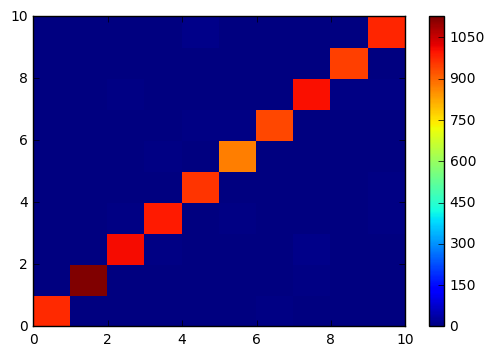

[[ 973    0    3    0    0    2    5    1    4    4]
 [   1 1126    1    1    0    0    3    7    0    3]
 [   1    2 1008    5    2    0    0   10    3    0]
 [   0    2    5  990    0    7    0    1    4    7]
 [   0    0    4    0  961    1    4    0    3    6]
 [   0    0    0    6    0  872    2    0    1    2]
 [   2    2    2    0    5    5  940    0    3    1]
 [   1    0    5    3    1    1    0 1006    6    6]
 [   2    3    4    4    1    3    4    0  948    0]
 [   0    0    0    1   12    1    0    3    2  980]]


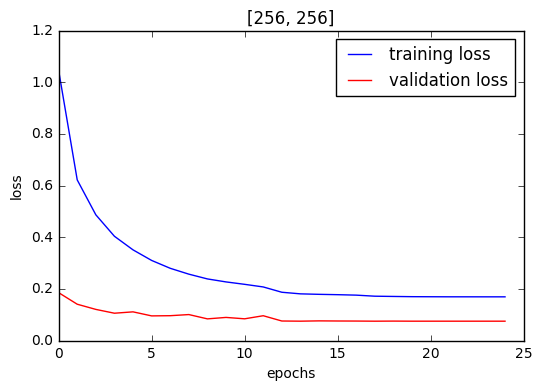

(784, 256)
(256,)
(256, 256)
(256,)
(256, 10)
(10,)


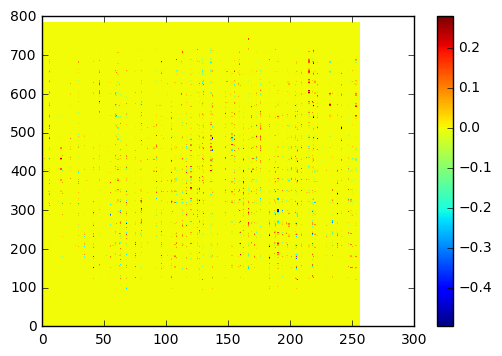

(784, 256)
('element portion close to zero: (<0.0001): ', 0.9191346460459183)


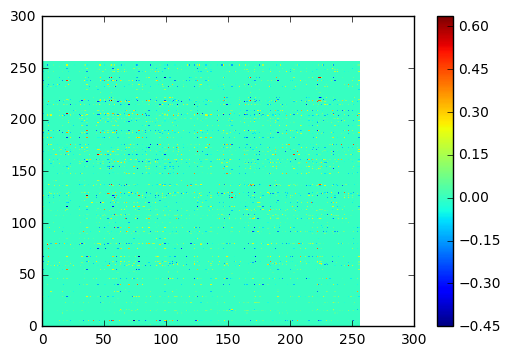

(256, 256)
('element portion close to zero: (<0.0001): ', 0.91156005859375)


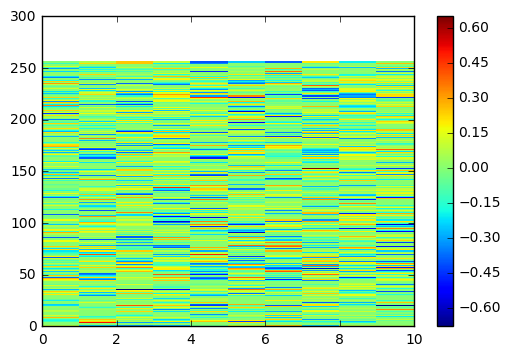

(256, 10)
('element portion close to zero: (<0.0001): ', 0.308984375)


In [78]:
plt.figure()
plt.pcolormesh(compareMap_s2)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_s2

plt.figure()
plt.title("[256, 256]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_s2.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_s2.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_s2.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_s2.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [79]:
print "L1 , 256, 128, 128"
his_s3, model_s3, compareMap_s3 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [256, 128, 128, 128])

L1 , 256, 128, 128
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 3s - loss: 1.0456 - val_loss: 0.1712
Epoch 2/200
48000/48000 [==============================] - 3s - loss: 0.6280 - val_loss: 0.1301
Epoch 3/200
48000/48000 [==============================] - 5s - loss: 0.5130 - val_loss: 0.1161
Epoch 4/200
48000/48000 [==============================] - 4s - loss: 0.4359 - val_loss: 0.1041
Epoch 5/200
48000/48000 [==============================] - 5s - loss: 0.3861 - val_loss: 0.1033
Epoch 6/200
48000/48000 [==============================] - 3s - loss: 0.3505 - val_loss: 0.1080
Epoch 7/200
48000/48000 [==============================] - 3s - loss: 0.3195 - val_loss: 0.0832
Epoch 8/200
48000/48000 [==============================] - 3s - loss: 0.2915 - val_loss: 0.0806
Epoch 9/200
48000/48000 [==============================] - 3s - loss: 0.2731 - val_loss: 0.0871
Epoch 10/200
48000/48000 [==============================] - 3s - lo

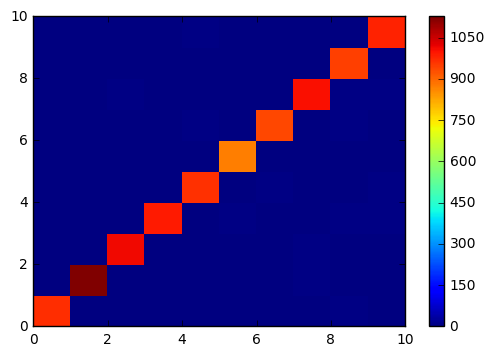

[[ 972    0    2    3    0    2    4    2    6    3]
 [   1 1127    2    1    0    0    4    7    0    2]
 [   1    4 1014    3    2    0    0    7    1    0]
 [   0    0    4  993    0    7    0    2    5    5]
 [   0    0    2    0  965    0    6    0    1    5]
 [   0    0    0    3    0  873    2    0    2    2]
 [   1    1    1    0    6    2  941    0    5    1]
 [   1    0    5    3    1    2    0 1006    5    6]
 [   2    3    2    3    0    4    1    0  947    0]
 [   2    0    0    1    8    2    0    4    2  985]]


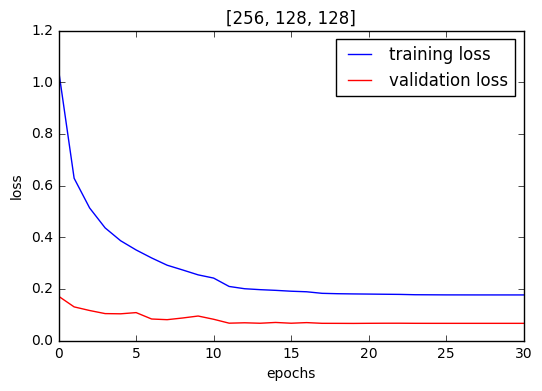

(784, 256)
(256,)
(256, 128)
(128,)
(128, 128)
(128,)
(128, 10)
(10,)


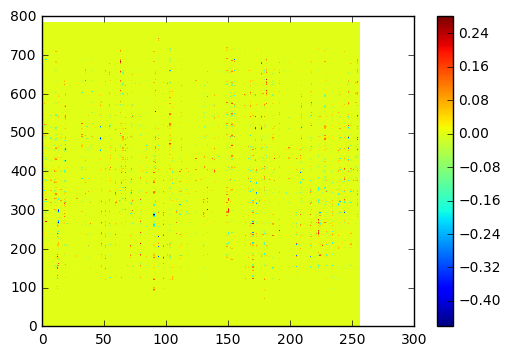

(784, 256)
('element portion close to zero: (<0.0001): ', 0.9150689572704082)


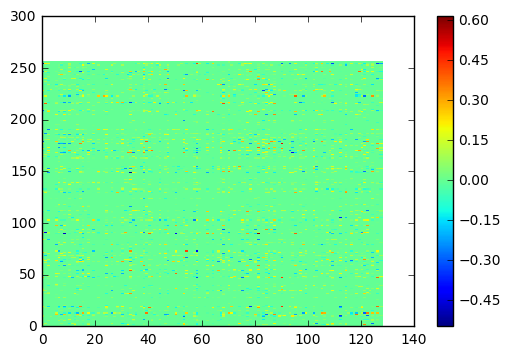

(256, 128)
('element portion close to zero: (<0.0001): ', 0.851043701171875)


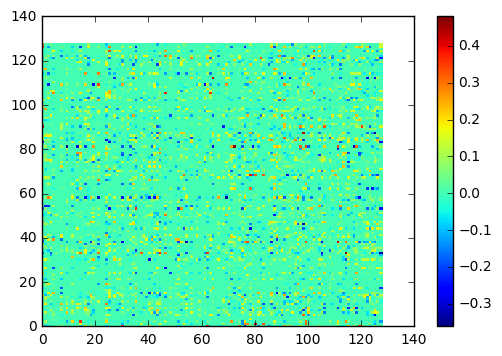

(128, 128)
('element portion close to zero: (<0.0001): ', 0.6944580078125)


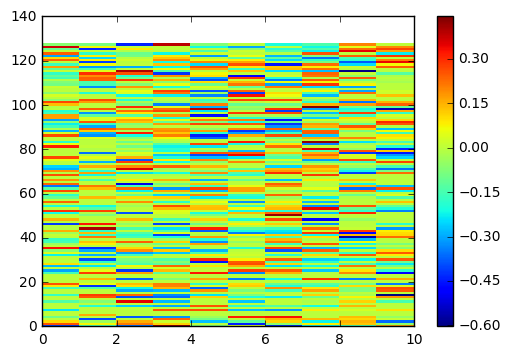

(128, 10)
('element portion close to zero: (<0.0001): ', 0.26328125)


In [80]:
plt.figure()
plt.pcolormesh(compareMap_s3)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_s3

plt.figure()
plt.title("[256, 128, 128]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_s3.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_s3.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_s3.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_s3.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [81]:
print "L1 , 128, 128, 128, 128"
his_s4, model_s4, compareMap_s4 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [128, 128, 128, 128, 128])

L1 , 128, 128, 128, 128
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 3s - loss: 0.9731 - val_loss: 0.1829
Epoch 2/200
48000/48000 [==============================] - 2s - loss: 0.6048 - val_loss: 0.1341
Epoch 3/200
48000/48000 [==============================] - 3s - loss: 0.5179 - val_loss: 0.1118
Epoch 4/200
48000/48000 [==============================] - 2s - loss: 0.4648 - val_loss: 0.0992
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 0.4233 - val_loss: 0.1043
Epoch 6/200
48000/48000 [==============================] - 2s - loss: 0.3887 - val_loss: 0.1091
Epoch 7/200
48000/48000 [==============================] - 2s - loss: 0.3599 - val_loss: 0.0992
Epoch 8/200
48000/48000 [==============================] - 3s - loss: 0.3195 - val_loss: 0.0790
Epoch 9/200
48000/48000 [==============================] - 2s - loss: 0.3069 - val_loss: 0.0770
Epoch 10/200
48000/48000 [==============================] - 2s

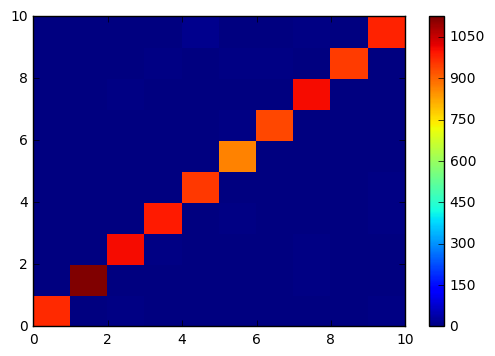

[[ 971    0    7    1    1    3    4    1    3    5]
 [   0 1124    0    0    0    0    3    5    1    3]
 [   2    1 1008    5    3    0    1    6    2    0]
 [   0    0    3  991    0    7    0    1    2    6]
 [   1    0    2    0  955    2    4    0    3    6]
 [   2    1    0    4    0  866    4    1    1    3]
 [   0    4    2    0    4    5  937    1    4    0]
 [   1    1    7    3    2    1    0 1007    2    3]
 [   3    4    3    5    1    5    5    1  952    2]
 [   0    0    0    1   16    3    0    5    4  981]]


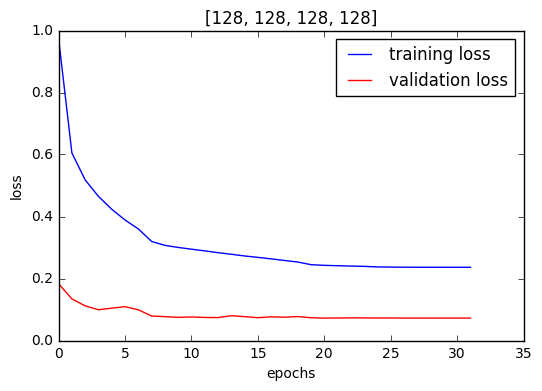

(784, 128)
(128,)
(128, 128)
(128,)
(128, 128)
(128,)
(128, 128)
(128,)
(128, 10)
(10,)


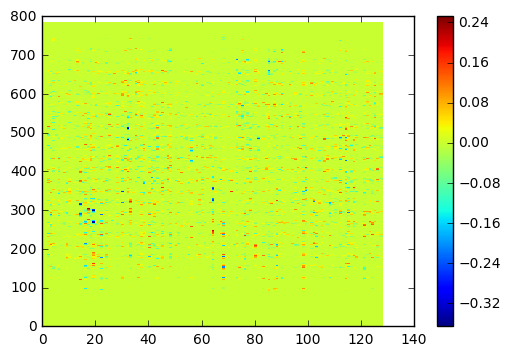

(784, 128)
('element portion close to zero: (<0.0001): ', 0.7824756855867347)


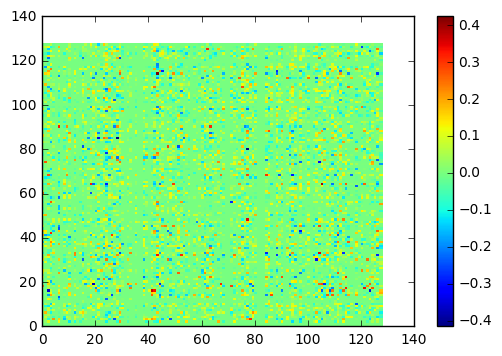

(128, 128)
('element portion close to zero: (<0.0001): ', 0.53472900390625)


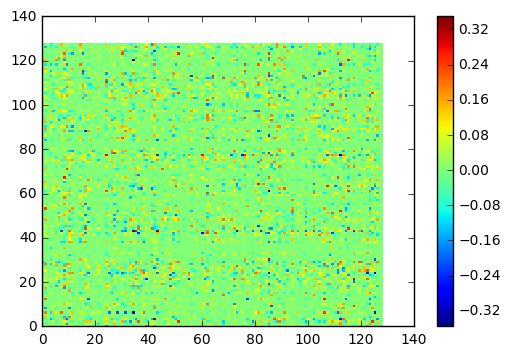

(128, 128)
('element portion close to zero: (<0.0001): ', 0.6231689453125)


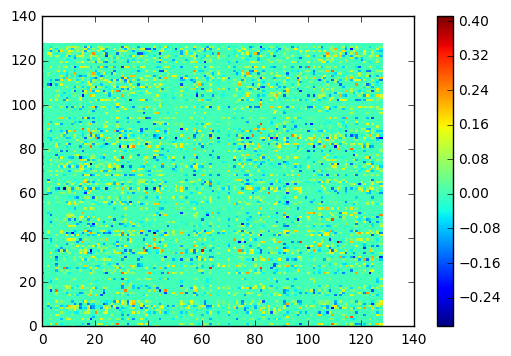

(128, 128)
('element portion close to zero: (<0.0001): ', 0.62164306640625)


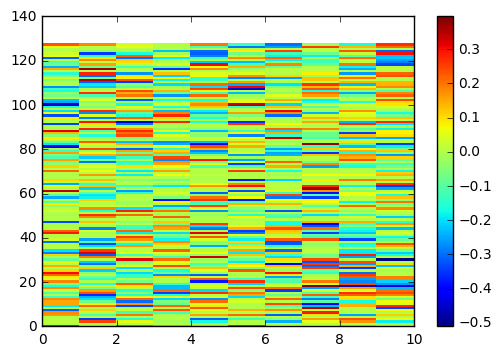

(128, 10)
('element portion close to zero: (<0.0001): ', 0.2125)


In [82]:
plt.figure()
plt.pcolormesh(compareMap_s4)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_s4

plt.figure()
plt.title("[128, 128, 128, 128]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_s4.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_s4.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_s4.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_s4.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [83]:
print "L1 , 64 * 8"
his_s5, model_s5, compareMap_s5 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [64, 64, 64, 64, 64, 64, 64, 64, 64])

L1 , 64 * 8
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 1.0177 - val_loss: 0.2363
Epoch 2/200
48000/48000 [==============================] - 1s - loss: 0.5256 - val_loss: 0.1789
Epoch 3/200
48000/48000 [==============================] - 1s - loss: 0.4547 - val_loss: 0.1691
Epoch 4/200
48000/48000 [==============================] - 1s - loss: 0.4160 - val_loss: 0.1435
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 0.3925 - val_loss: 0.1306
Epoch 6/200
48000/48000 [==============================] - 1s - loss: 0.3696 - val_loss: 0.1345
Epoch 7/200
48000/48000 [==============================] - 2s - loss: 0.3560 - val_loss: 0.1108
Epoch 8/200
48000/48000 [==============================] - 1s - loss: 0.3472 - val_loss: 0.1191
Epoch 9/200
48000/48000 [==============================] - 2s - loss: 0.3339 - val_loss: 0.1491
Epoch 10/200
48000/48000 [==============================] - 2s - loss: 0.3

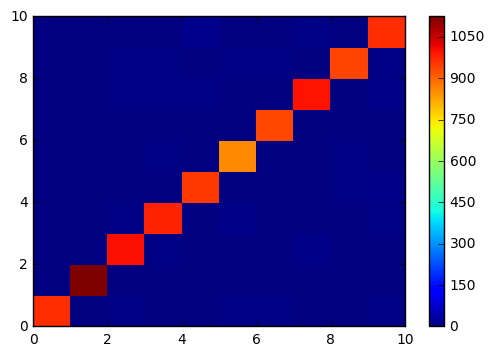

[[ 969    0    7    0    3    6    5    1    4    6]
 [   0 1124    0    0    0    0    3    4    1    2]
 [   2    1 1004    6    2    0    0   10    1    0]
 [   1    3    5  982    1   10    0    3    4    6]
 [   0    0    1    0  955    3    2    3    5    9]
 [   1    1    0    8    0  859    3    0    7    2]
 [   3    2    1    0    2    4  939    1    4    1]
 [   1    2    8    5    5    1    1  999    3   10]
 [   3    2    5    5    0    6    5    2  942    5]
 [   0    0    1    4   14    3    0    5    3  968]]


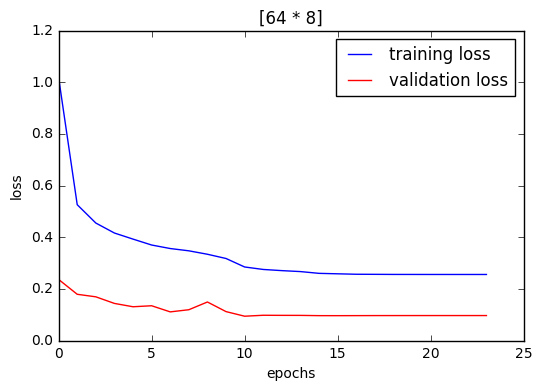

(784, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


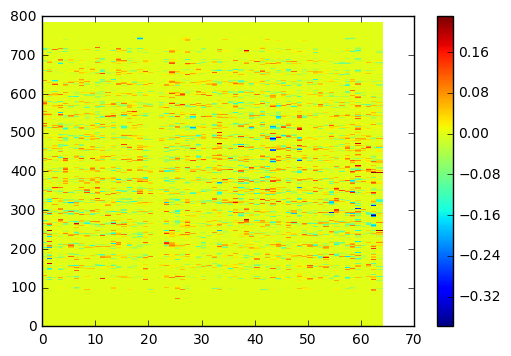

(784, 64)
('element portion close to zero: (<0.0001): ', 0.5730229591836735)


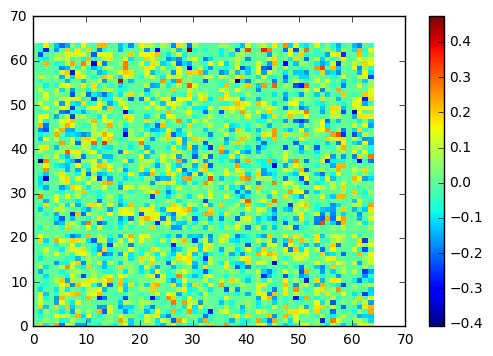

(64, 64)
('element portion close to zero: (<0.0001): ', 0.179931640625)


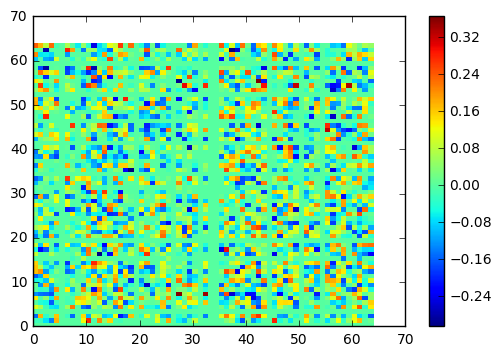

(64, 64)
('element portion close to zero: (<0.0001): ', 0.338623046875)


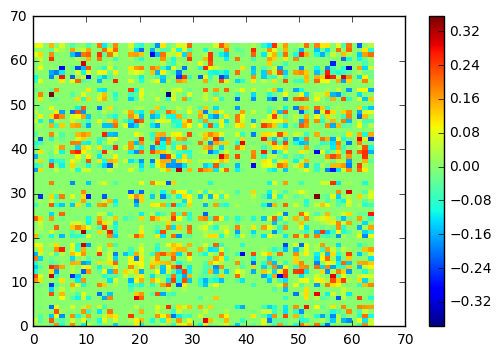

(64, 64)
('element portion close to zero: (<0.0001): ', 0.4345703125)


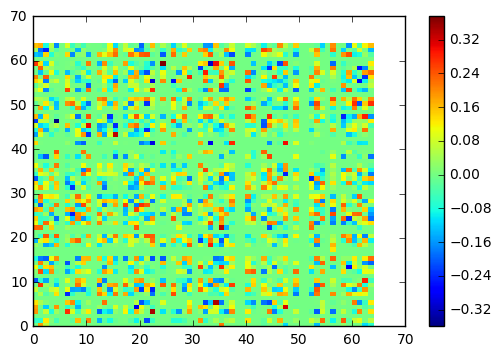

(64, 64)
('element portion close to zero: (<0.0001): ', 0.47119140625)


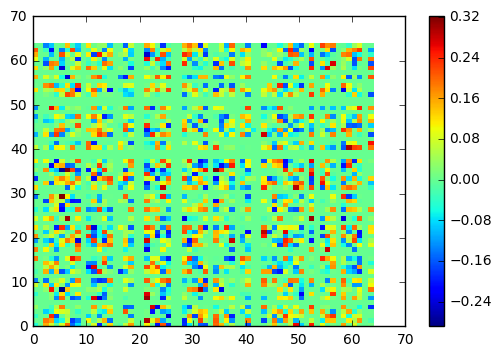

(64, 64)
('element portion close to zero: (<0.0001): ', 0.49072265625)


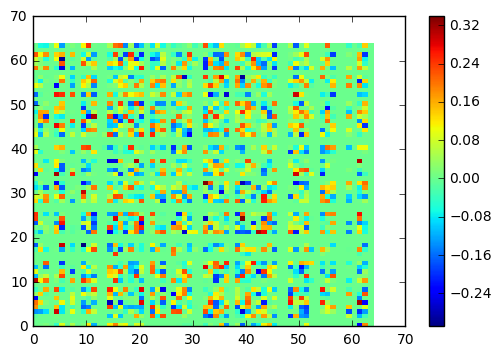

(64, 64)
('element portion close to zero: (<0.0001): ', 0.52392578125)


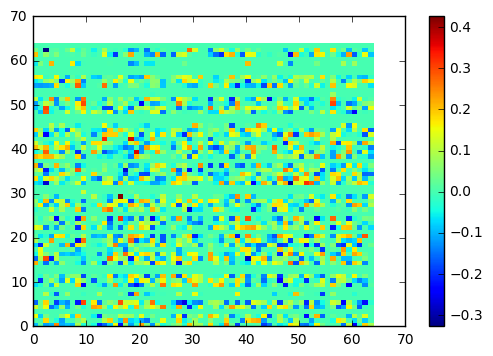

(64, 64)
('element portion close to zero: (<0.0001): ', 0.439208984375)


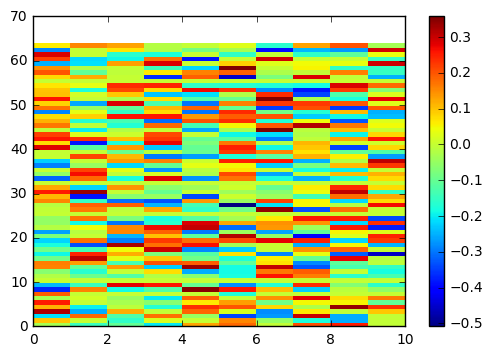

(64, 10)
('element portion close to zero: (<0.0001): ', 0.0984375)


In [84]:
plt.figure()
plt.pcolormesh(compareMap_s5)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_s5

plt.figure()
plt.title("[64 * 8]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_s5.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_s5.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_s5.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_s5.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [85]:
print "L1 , 64"
print "[64]"
his_ss1, model_ss1, compareMap_ss1 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [64])

L1 , 64
[64]
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 1s - loss: 0.7019 - val_loss: 0.2853
Epoch 2/200
48000/48000 [==============================] - 1s - loss: 0.3980 - val_loss: 0.2322
Epoch 3/200
48000/48000 [==============================] - 1s - loss: 0.3425 - val_loss: 0.2053
Epoch 4/200
48000/48000 [==============================] - 1s - loss: 0.3089 - val_loss: 0.1825
Epoch 5/200
48000/48000 [==============================] - 1s - loss: 0.2839 - val_loss: 0.1674
Epoch 6/200
48000/48000 [==============================] - 0s - loss: 0.2670 - val_loss: 0.1575
Epoch 7/200
48000/48000 [==============================] - 0s - loss: 0.2533 - val_loss: 0.1460
Epoch 8/200
48000/48000 [==============================] - 0s - loss: 0.2421 - val_loss: 0.1395
Epoch 9/200
48000/48000 [==============================] - 0s - loss: 0.2321 - val_loss: 0.1326
Epoch 10/200
48000/48000 [==============================] - 1s - loss: 0.

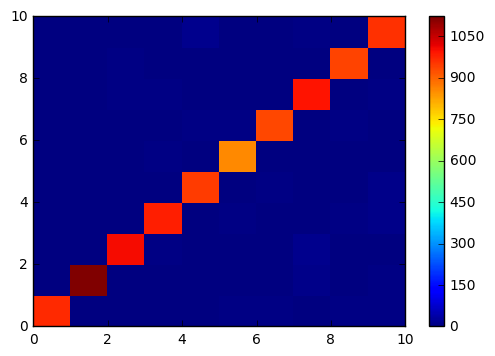

[[ 971    0    4    0    1    6    7    1    6    5]
 [   0 1122    3    0    0    1    3    9    0    6]
 [   2    4 1005    6    2    2    2   14    3    0]
 [   0    0    4  986    0    8    0    1    6    9]
 [   0    0    3    0  950    1    5    0    3   12]
 [   1    2    0    6    1  858    2    0    4    4]
 [   2    3    2    0    7    8  936    0    6    1]
 [   1    0    6    5    2    1    0  996    4    8]
 [   3    4    5    4    4    4    3    1  940    2]
 [   0    0    0    3   15    3    0    6    2  962]]


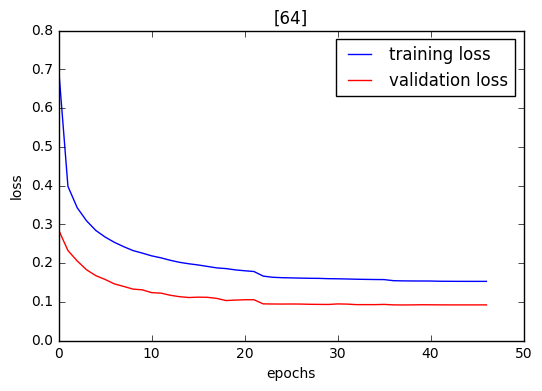

(784, 64)
(64,)
(64, 10)
(10,)


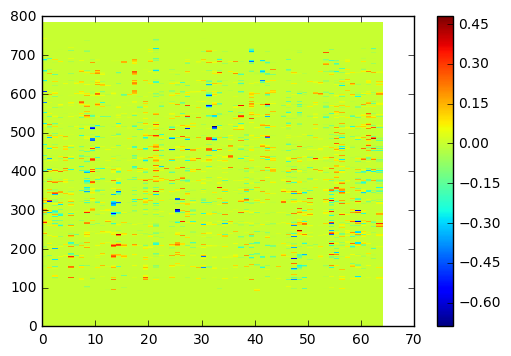

(784, 64)
('element portion close to zero: (<0.0001): ', 0.760383450255102)


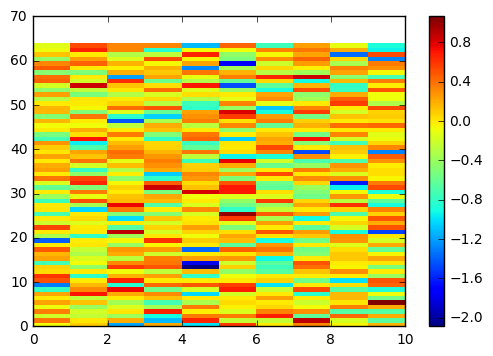

(64, 10)
('element portion close to zero: (<0.0001): ', 0.0546875)


In [86]:
plt.figure()
plt.pcolormesh(compareMap_ss1)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_ss1

plt.figure()
plt.title("[64]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_ss1.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_ss1.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_ss1.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_ss1.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [87]:
print "L1 , 64"
print "[32, 32]"
his_ss2, model_ss2, compareMap_ss2 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [32, 32, 32])

L1 , 64
[32, 32]
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 1s - loss: 0.7773 - val_loss: 0.2900
Epoch 2/200
48000/48000 [==============================] - 1s - loss: 0.3675 - val_loss: 0.2377
Epoch 3/200
48000/48000 [==============================] - 1s - loss: 0.3176 - val_loss: 0.2062
Epoch 4/200
48000/48000 [==============================] - 1s - loss: 0.2881 - val_loss: 0.1872
Epoch 5/200
48000/48000 [==============================] - 1s - loss: 0.2683 - val_loss: 0.1753
Epoch 6/200
48000/48000 [==============================] - 1s - loss: 0.2520 - val_loss: 0.1637
Epoch 7/200
48000/48000 [==============================] - 0s - loss: 0.2401 - val_loss: 0.1628
Epoch 8/200
48000/48000 [==============================] - 0s - loss: 0.2304 - val_loss: 0.1497
Epoch 9/200
48000/48000 [==============================] - 0s - loss: 0.2212 - val_loss: 0.1474
Epoch 10/200
48000/48000 [==============================] - 1s - loss

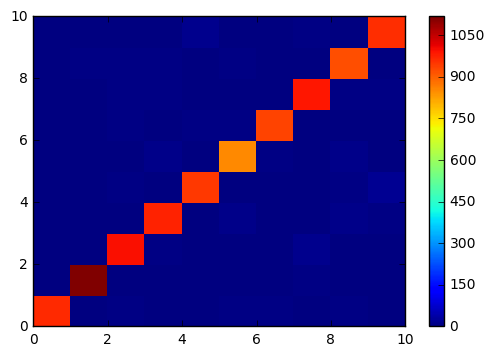

[[ 968    0    5    0    1    5    6    2    6    4]
 [   0 1118    2    0    0    1    3    7    0    3]
 [   0    3  998    7    2    1    1   17    3    0]
 [   0    2    4  978    1    9    0    2   11    5]
 [   1    0    5    0  952    0    3    0    6   21]
 [   2    0    0    9    0  855    6    0   10    3]
 [   3    4    5    0    5    8  937    0    4    1]
 [   3    0    7    7    2    2    0  990    7    7]
 [   1    8    6    7    3    7    2    2  924    4]
 [   2    0    0    2   16    4    0    8    3  961]]


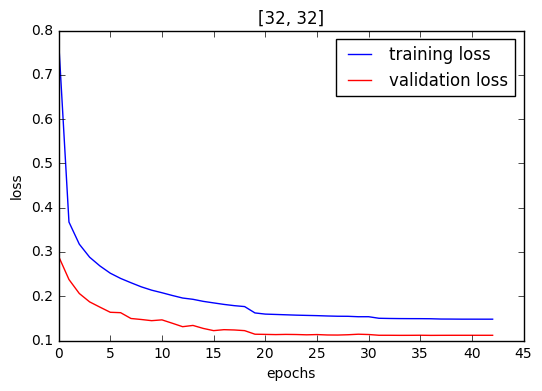

(784, 32)
(32,)
(32, 32)
(32,)
(32, 10)
(10,)


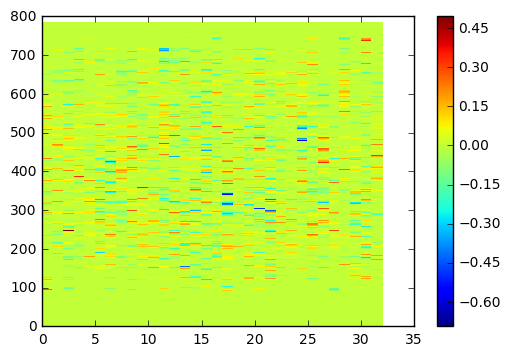

(784, 32)
('element portion close to zero: (<0.0001): ', 0.6173867984693877)


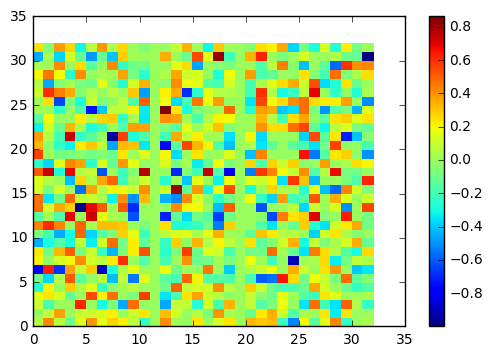

(32, 32)
('element portion close to zero: (<0.0001): ', 0.08984375)


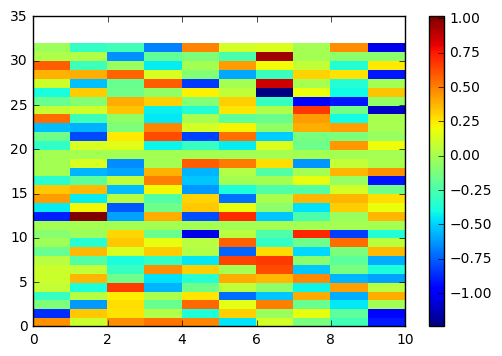

(32, 10)
('element portion close to zero: (<0.0001): ', 0.078125)


In [88]:
plt.figure()
plt.pcolormesh(compareMap_ss2)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_ss2

plt.figure()
plt.title("[32, 32]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_ss2.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_ss2.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_ss2.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_ss2.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [89]:
print "L1 , 64"
print "[16, 16, 16, 16]"
his_ss3, model_ss3, compareMap_ss3 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [16, 16, 16, 16, 16])

L1 , 64
[16, 16, 16, 16]
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 0s - loss: 1.0886 - val_loss: 0.3950
Epoch 2/200
48000/48000 [==============================] - 0s - loss: 0.4091 - val_loss: 0.2769
Epoch 3/200
48000/48000 [==============================] - 0s - loss: 0.3387 - val_loss: 0.2436
Epoch 4/200
48000/48000 [==============================] - 1s - loss: 0.3068 - val_loss: 0.2218
Epoch 5/200
48000/48000 [==============================] - 1s - loss: 0.2839 - val_loss: 0.2042
Epoch 6/200
48000/48000 [==============================] - 0s - loss: 0.2678 - val_loss: 0.1941
Epoch 7/200
48000/48000 [==============================] - 0s - loss: 0.2546 - val_loss: 0.1933
Epoch 8/200
48000/48000 [==============================] - 1s - loss: 0.2446 - val_loss: 0.1817
Epoch 9/200
48000/48000 [==============================] - 0s - loss: 0.2350 - val_loss: 0.1726
Epoch 10/200
48000/48000 [==============================] - 0

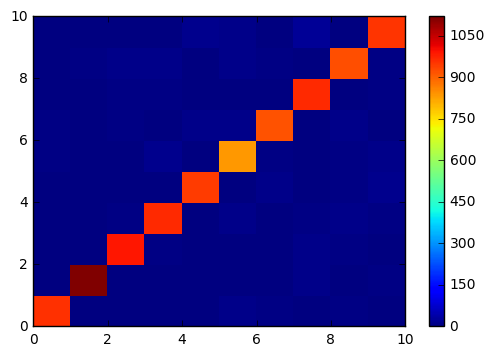

[[ 959    0    4    2    1   11    6    2    8    4]
 [   1 1119    1    1    1    1    3   10    2    5]
 [   3    3  989    8    4    1    4    9    5    0]
 [   1    2    8  968    1   11    0    8    9    8]
 [   0    0    3    0  945    0    9    4    5   16]
 [   6    1    1   15    0  837    8    0    6   11]
 [   7    1    7    0    9    9  921    0    9    0]
 [   2    1    7    6    3    0    0  969    4    7]
 [   1    8   12    9    1   11    7    4  923    5]
 [   0    0    0    1   17   11    0   22    3  953]]


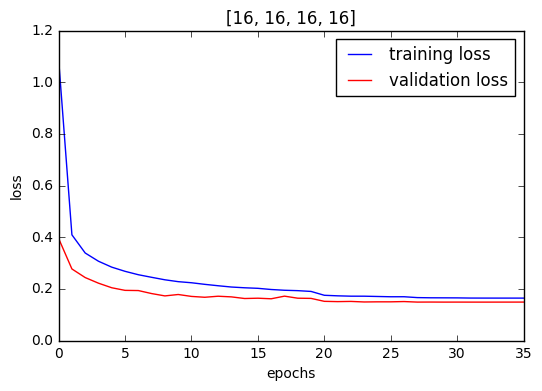

(784, 16)
(16,)
(16, 16)
(16,)
(16, 16)
(16,)
(16, 16)
(16,)
(16, 10)
(10,)


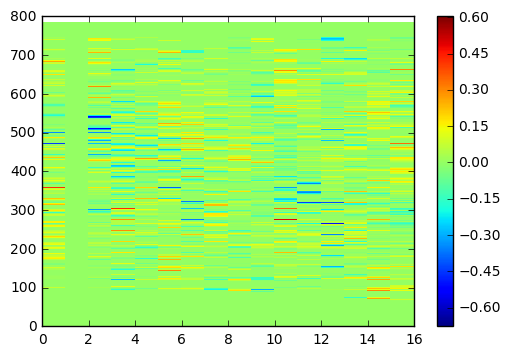

(784, 16)
('element portion close to zero: (<0.0001): ', 0.4960140306122449)


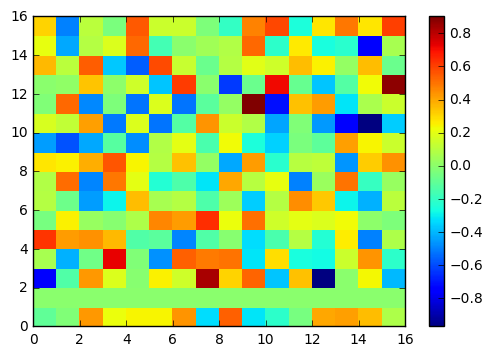

(16, 16)
('element portion close to zero: (<0.0001): ', 0.0625)


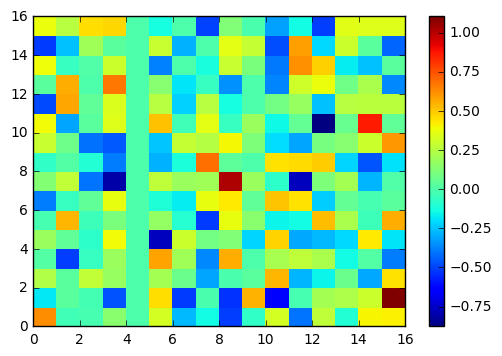

(16, 16)
('element portion close to zero: (<0.0001): ', 0.06640625)


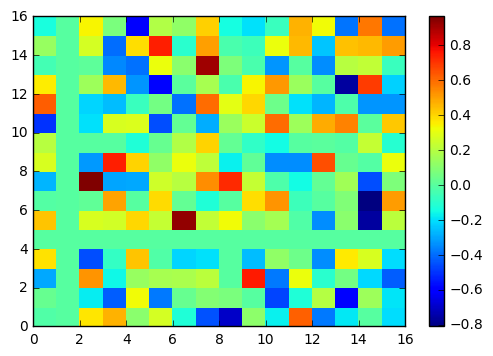

(16, 16)
('element portion close to zero: (<0.0001): ', 0.1328125)


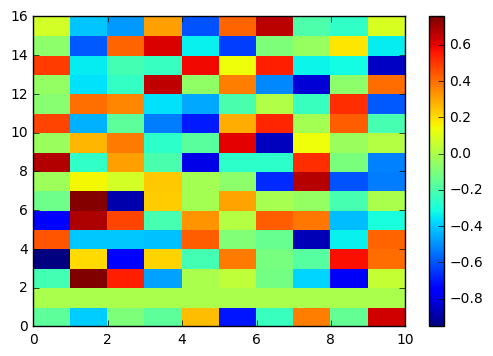

(16, 10)
('element portion close to zero: (<0.0001): ', 0.06875)


In [90]:
plt.figure()
plt.pcolormesh(compareMap_ss3)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_ss3

plt.figure()
plt.title("[16, 16, 16, 16]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_ss3.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_ss3.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_ss3.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_ss3.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

In [91]:
print "L1 , 64"
print "[8,8,8,8,8,8,8,8,8]"
his_ss4, model_ss4, compareMap_ss4 = trainModel(Xtr, ytr, Xts, yts, c_L1=0.0001, layers = [8,8,8,8,8,8,8,8,8])

L1 , 64
[8,8,8,8,8,8,8,8,8]
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 2s - loss: 1.8941 - val_loss: 1.5364
Epoch 2/200
48000/48000 [==============================] - 1s - loss: 1.3885 - val_loss: 1.0807
Epoch 3/200
48000/48000 [==============================] - 1s - loss: 0.9045 - val_loss: 0.6705
Epoch 4/200
48000/48000 [==============================] - 1s - loss: 0.6329 - val_loss: 0.5311
Epoch 5/200
48000/48000 [==============================] - 0s - loss: 0.5434 - val_loss: 0.4753
Epoch 6/200
48000/48000 [==============================] - 1s - loss: 0.5045 - val_loss: 0.4596
Epoch 7/200
48000/48000 [==============================] - 1s - loss: 0.4764 - val_loss: 0.4454
Epoch 8/200
48000/48000 [==============================] - 1s - loss: 0.4580 - val_loss: 0.4280
Epoch 9/200
48000/48000 [==============================] - 0s - loss: 0.4412 - val_loss: 0.4120
Epoch 10/200
48000/48000 [==============================] 

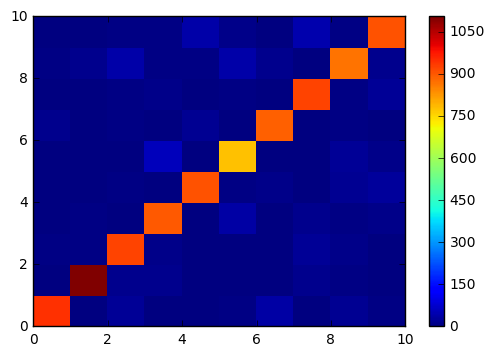

[[ 947    1   24    4    0    7   37    1   19    8]
 [   0 1104   13   15    2    2    2   14    7    4]
 [   6    7  926   10    4    3    3   25   12    0]
 [   0    6    4  900    1   36    1   13    5    9]
 [   3    0    7    0  909    7   11    3   19   27]
 [   0    1    1   57    0  780    1    0   22   10]
 [  14    0    6    1   21    2  890    0    7    2]
 [   3    0    5   10    0    6    0  923    5   23]
 [   7   15   40    8    6   39   13    4  870   17]
 [   0    1    6    5   39   10    0   45    8  909]]


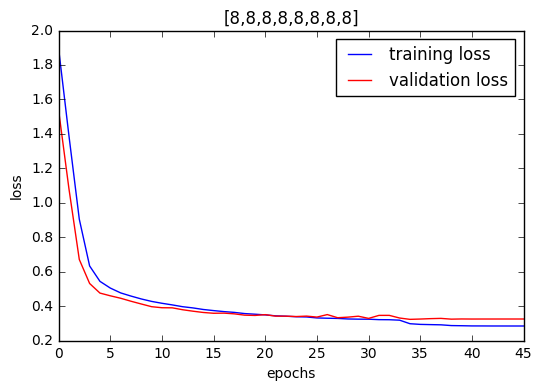

(784, 8)
(8,)
(8, 8)
(8,)
(8, 8)
(8,)
(8, 8)
(8,)
(8, 8)
(8,)
(8, 8)
(8,)
(8, 8)
(8,)
(8, 8)
(8,)
(8, 10)
(10,)


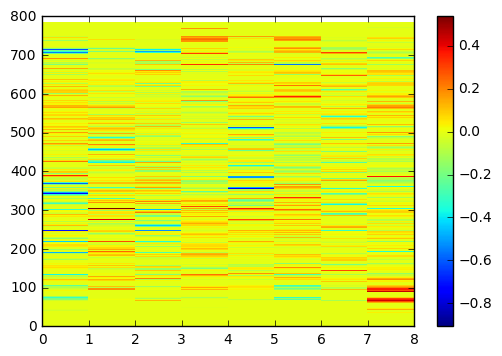

(784, 8)
('element portion close to zero: (<0.0001): ', 0.31600765306122447)


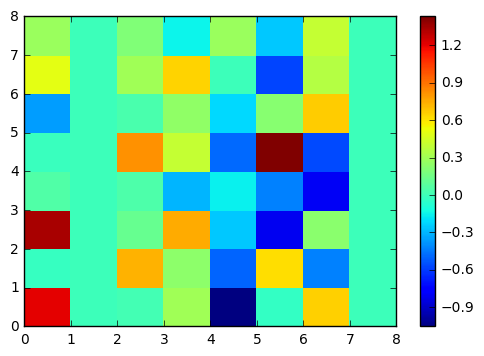

(8, 8)
('element portion close to zero: (<0.0001): ', 0.25)


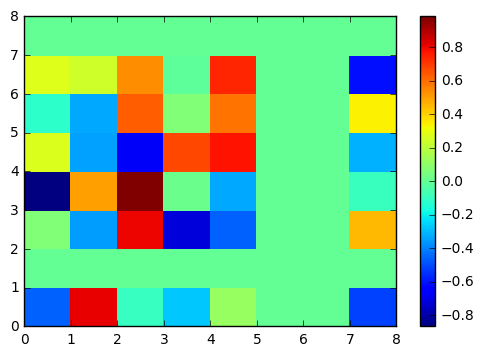

(8, 8)
('element portion close to zero: (<0.0001): ', 0.4375)


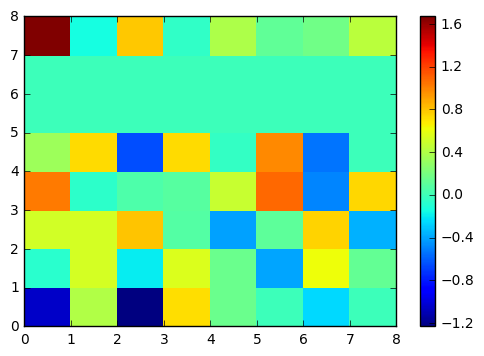

(8, 8)
('element portion close to zero: (<0.0001): ', 0.265625)


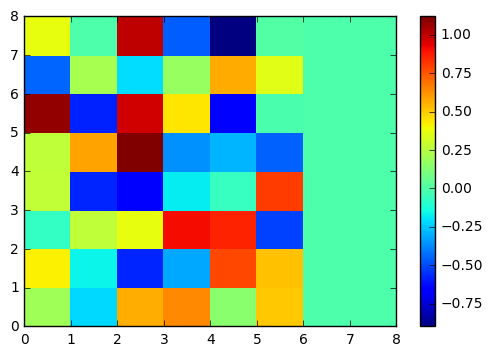

(8, 8)
('element portion close to zero: (<0.0001): ', 0.25)


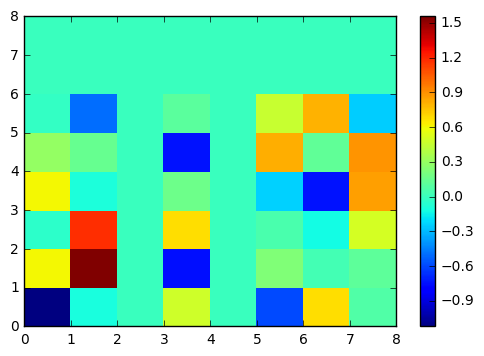

(8, 8)
('element portion close to zero: (<0.0001): ', 0.4375)


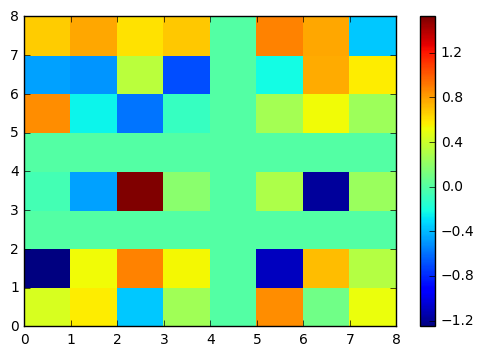

(8, 8)
('element portion close to zero: (<0.0001): ', 0.34375)


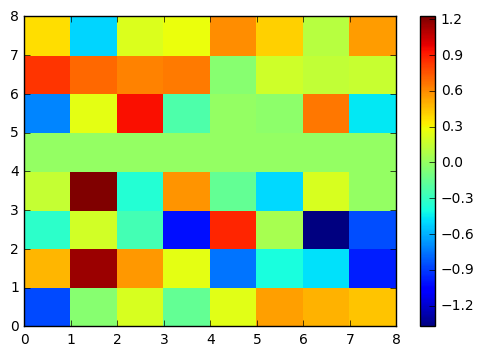

(8, 8)
('element portion close to zero: (<0.0001): ', 0.125)


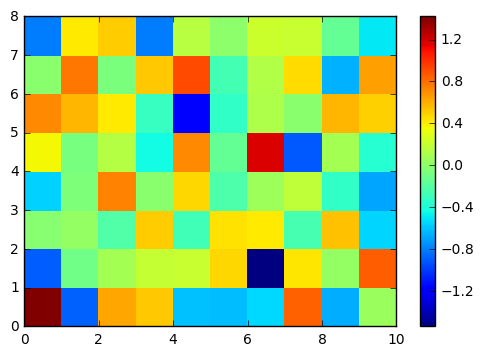

(8, 10)
('element portion close to zero: (<0.0001): ', 0.0)


In [92]:
plt.figure()
plt.pcolormesh(compareMap_ss4)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_ss4

plt.figure()
plt.title("[8,8,8,8,8,8,8,8]")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_ss4.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_ss4.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_ss4.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_ss4.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

## Nonlinear activations
### relu, sigmoid, tanh

### relu

In [102]:
print "relu"
his_relu, model_relu, compareMap_relu = trainModel(Xtr, ytr, Xts, yts, 
                                                c_L1=0.00001, layers = [128, 128, 64, 64, 64, 64],
                                               act = 'relu')

relu
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 4s - loss: 0.5038 - val_loss: 0.1873
Epoch 2/200
48000/48000 [==============================] - 4s - loss: 0.2082 - val_loss: 0.1383
Epoch 3/200
48000/48000 [==============================] - 4s - loss: 0.1629 - val_loss: 0.1173
Epoch 4/200
48000/48000 [==============================] - 3s - loss: 0.1396 - val_loss: 0.1000
Epoch 5/200
48000/48000 [==============================] - 2s - loss: 0.1195 - val_loss: 0.1285
Epoch 6/200
48000/48000 [==============================] - 3s - loss: 0.1089 - val_loss: 0.0948
Epoch 7/200
48000/48000 [==============================] - 4s - loss: 0.1014 - val_loss: 0.1016
Epoch 8/200
48000/48000 [==============================] - 4s - loss: 0.0901 - val_loss: 0.0974
Epoch 9/200
48000/48000 [==============================] - 4s - loss: 0.0874 - val_loss: 0.0932
Epoch 10/200
48000/48000 [==============================] - 3s - loss: 0.0815 - v

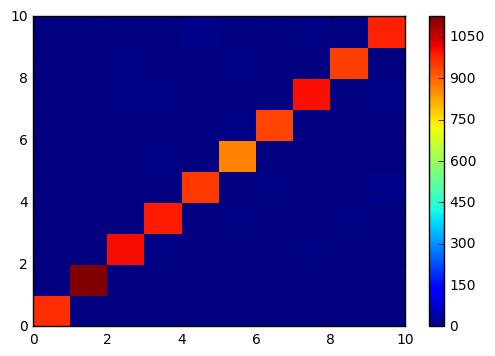

[[ 969    0    3    0    2    1    1    1    3    2]
 [   1 1124    1    0    1    0    2    4    0    3]
 [   0    1 1009    5    3    0    1    6    4    0]
 [   2    1    3  990    0    7    0    2    5    4]
 [   0    0    2    1  957    0    5    0    2    9]
 [   1    3    0    5    0  869    4    1    4    3]
 [   4    2    2    0    4    5  941    0    3    0]
 [   1    1    6    5    2    1    0 1004    3    5]
 [   2    3    6    2    0    5    4    3  948    2]
 [   0    0    0    2   13    4    0    7    2  981]]


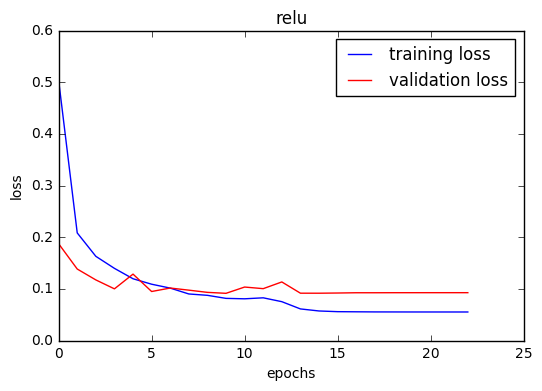

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


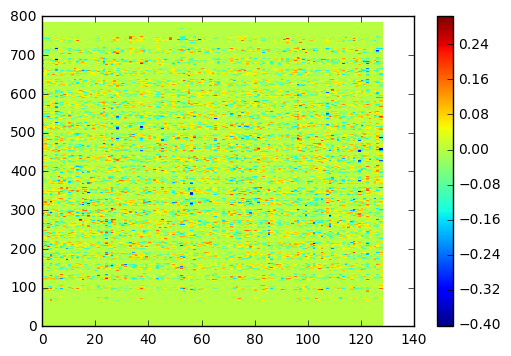

(784, 128)
('element portion close to zero: (<0.0001): ', 0.41940369897959184)


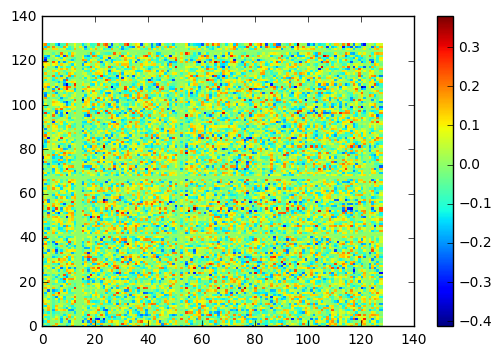

(128, 128)
('element portion close to zero: (<0.0001): ', 0.07525634765625)


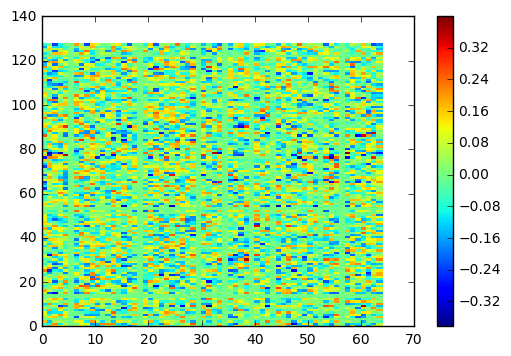

(128, 64)
('element portion close to zero: (<0.0001): ', 0.152099609375)


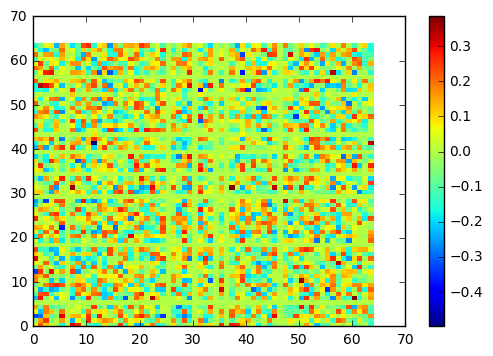

(64, 64)
('element portion close to zero: (<0.0001): ', 0.20263671875)


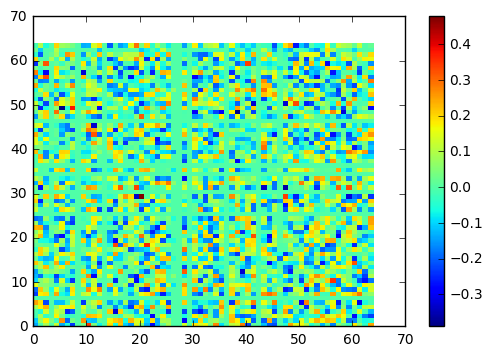

(64, 64)
('element portion close to zero: (<0.0001): ', 0.22119140625)


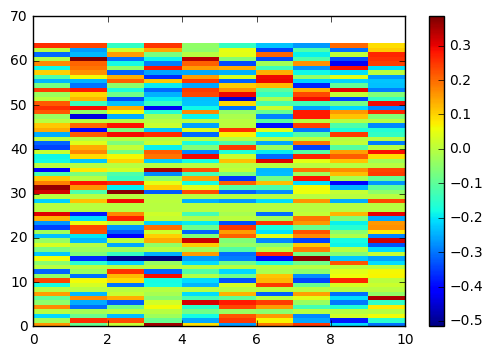

(64, 10)
('element portion close to zero: (<0.0001): ', 0.1375)


In [103]:
plt.figure()
plt.pcolormesh(compareMap_relu)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_relu

plt.figure()
plt.title("relu")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_relu.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_relu.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_relu.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_relu.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

### sigmoid, l1, c = 0.00001

In [98]:
print "sigmoid"
his_sig, model_sig, compareMap_sig = trainModel(Xtr, ytr, Xts, yts, 
                                                c_L1=0.00001, layers = [128, 128, 64, 64, 64, 64],
                                               act = 'sigmoid')

sigmoid
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 5s - loss: 2.1488 - val_loss: 1.7867
Epoch 2/200
48000/48000 [==============================] - 4s - loss: 1.5861 - val_loss: 1.3350
Epoch 3/200
48000/48000 [==============================] - 3s - loss: 1.2409 - val_loss: 0.9450
Epoch 4/200
48000/48000 [==============================] - 4s - loss: 0.8022 - val_loss: 0.5323
Epoch 5/200
48000/48000 [==============================] - 3s - loss: 0.5484 - val_loss: 0.4544
Epoch 6/200
48000/48000 [==============================] - 8s - loss: 0.4570 - val_loss: 0.3467
Epoch 7/200
48000/48000 [==============================] - 3s - loss: 0.4012 - val_loss: 0.3189
Epoch 8/200
48000/48000 [==============================] - 4s - loss: 0.3664 - val_loss: 0.2825
Epoch 9/200
48000/48000 [==============================] - 3s - loss: 0.3366 - val_loss: 0.2704
Epoch 10/200
48000/48000 [==============================] - 3s - loss: 0.3145 

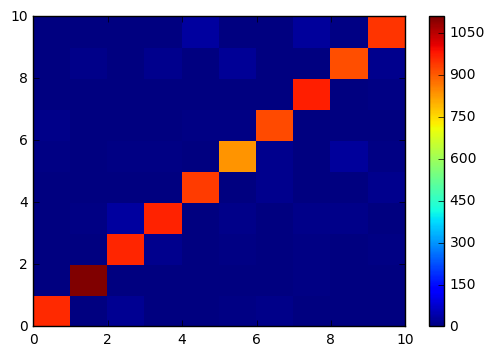

[[ 960    0   18    0    2    6    9    0    0    3]
 [   0 1109    0    2    0    0    2    7    3    2]
 [   3    1  962   13    3    5    0    6    1    5]
 [   0    6   34  968    0   10    0   10   12    4]
 [   0    0    2    0  936    1   14    1    3   16]
 [   7    3    7    8    0  836   13    1   26    6]
 [   9    1    1    0    8    7  919    0    1    1]
 [   1    3    3    3    1    0    0  972    3    7]
 [   0   12    3   15    1   24    1    4  917   17]
 [   0    0    2    1   31    3    0   27    8  948]]


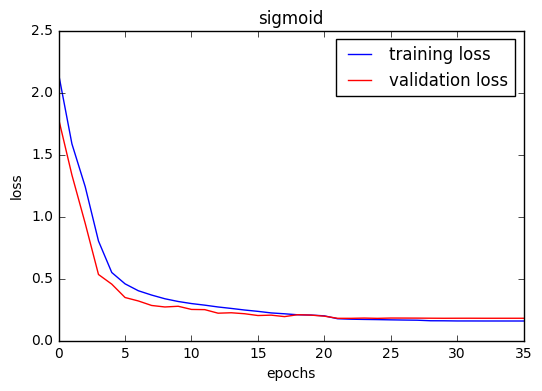

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


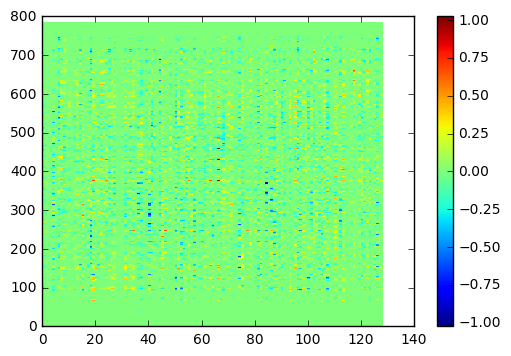

(784, 128)
('element portion close to zero: (<0.0001): ', 0.48215282206632654)


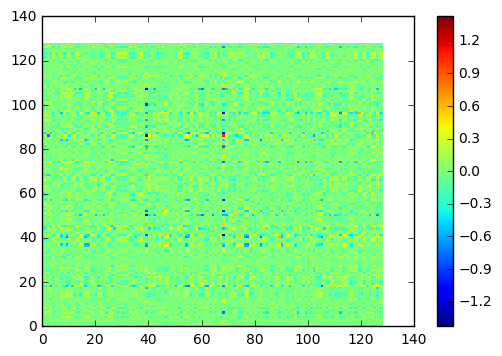

(128, 128)
('element portion close to zero: (<0.0001): ', 0.13970947265625)


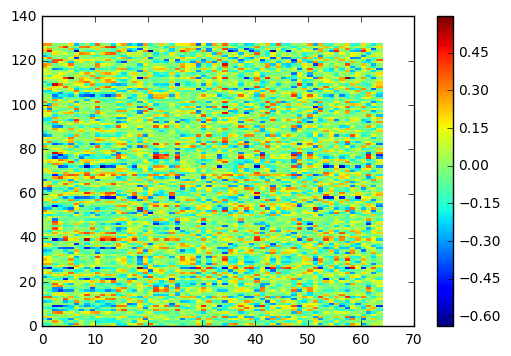

(128, 64)
('element portion close to zero: (<0.0001): ', 0.05224609375)


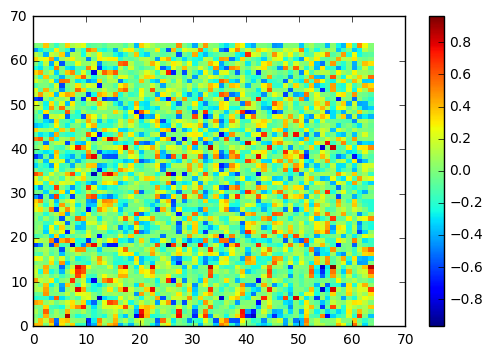

(64, 64)
('element portion close to zero: (<0.0001): ', 0.0205078125)


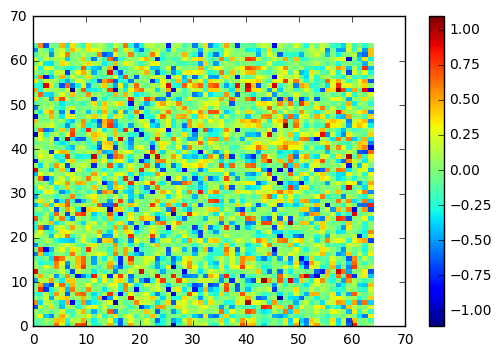

(64, 64)
('element portion close to zero: (<0.0001): ', 0.031494140625)


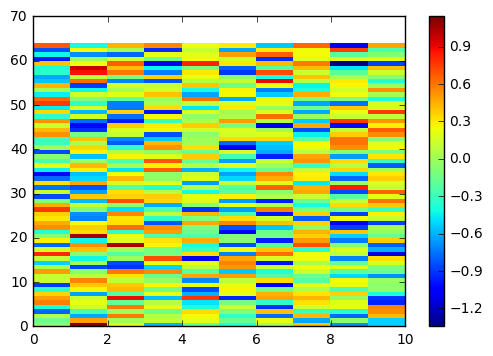

(64, 10)
('element portion close to zero: (<0.0001): ', 0.0015625)


In [99]:
plt.figure()
plt.pcolormesh(compareMap_sig)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_sig

plt.figure()
plt.title("sigmoid")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_sig.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_sig.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_sig.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_sig.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

### tanh, l1, c = 0.00001

In [100]:
print "sigmoid"
his_tanh, model_tanh, compareMap_tanh = trainModel(Xtr, ytr, Xts, yts, 
                                                c_L1=0.00001, layers = [128, 128, 64, 64, 64, 64],
                                               act = 'tanh')

sigmoid
Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 6s - loss: 0.4655 - val_loss: 0.2189
Epoch 2/200
48000/48000 [==============================] - 4s - loss: 0.2351 - val_loss: 0.1502
Epoch 3/200
48000/48000 [==============================] - 3s - loss: 0.1827 - val_loss: 0.1388
Epoch 4/200
48000/48000 [==============================] - 3s - loss: 0.1553 - val_loss: 0.1237
Epoch 5/200
48000/48000 [==============================] - 4s - loss: 0.1360 - val_loss: 0.1054
Epoch 6/200
48000/48000 [==============================] - 3s - loss: 0.1222 - val_loss: 0.1039
Epoch 7/200
48000/48000 [==============================] - 3s - loss: 0.1116 - val_loss: 0.0981
Epoch 8/200
48000/48000 [==============================] - 3s - loss: 0.1045 - val_loss: 0.1031
Epoch 9/200
48000/48000 [==============================] - 4s - loss: 0.0961 - val_loss: 0.1047
Epoch 10/200
48000/48000 [==============================] - 4s - loss: 0.0917 

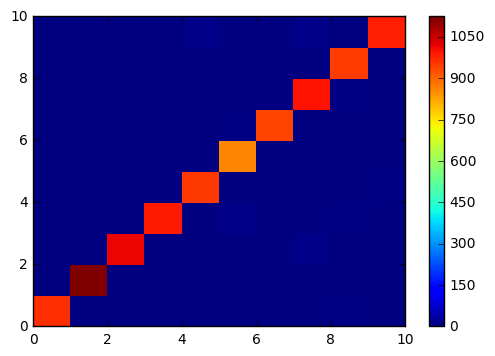

[[ 969    0    3    0    2    3    4    0    5    3]
 [   1 1124    0    0    1    0    2    2    0    2]
 [   1    1 1016    4    3    0    1   10    1    0]
 [   0    3    3  992    1   13    1    4    6    4]
 [   1    0    1    0  957    1    3    1    1    8]
 [   3    2    0    3    2  862    3    0    1    1]
 [   3    2    2    0    3    5  942    0    1    1]
 [   1    1    4    3    1    1    0  999    5    4]
 [   1    2    3    4    0    3    2    2  952    2]
 [   0    0    0    4   12    4    0   10    2  984]]


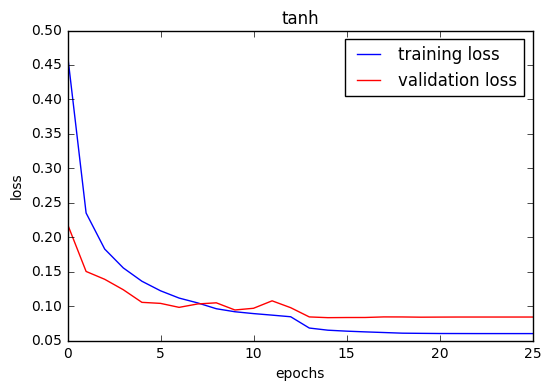

(784, 128)
(128,)
(128, 128)
(128,)
(128, 64)
(64,)
(64, 64)
(64,)
(64, 64)
(64,)
(64, 10)
(10,)


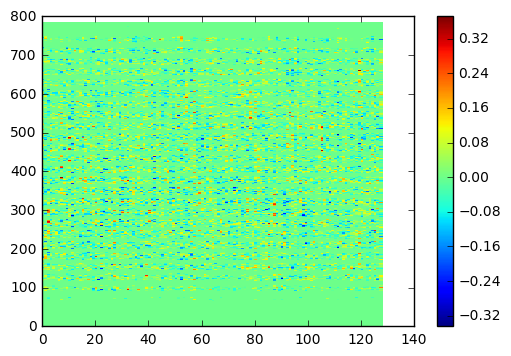

(784, 128)
('element portion close to zero: (<0.0001): ', 0.476871412627551)


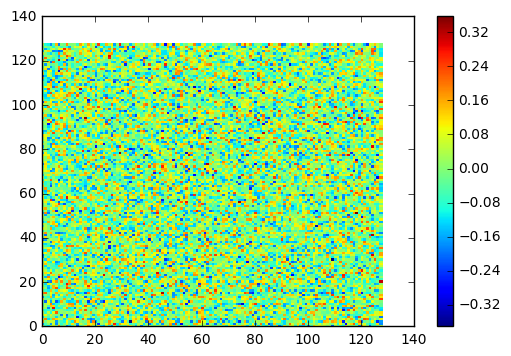

(128, 128)
('element portion close to zero: (<0.0001): ', 0.013916015625)


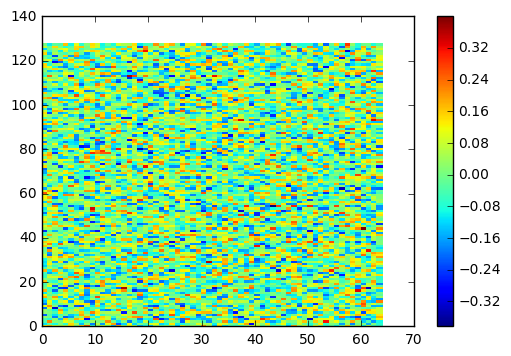

(128, 64)
('element portion close to zero: (<0.0001): ', 0.0081787109375)


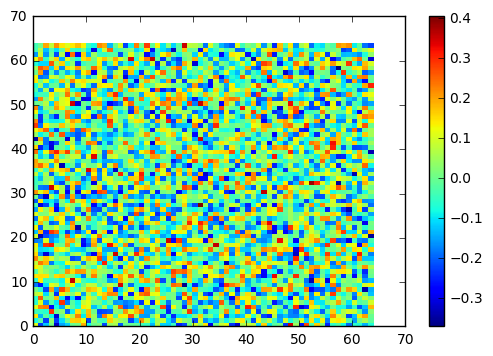

(64, 64)
('element portion close to zero: (<0.0001): ', 0.005615234375)


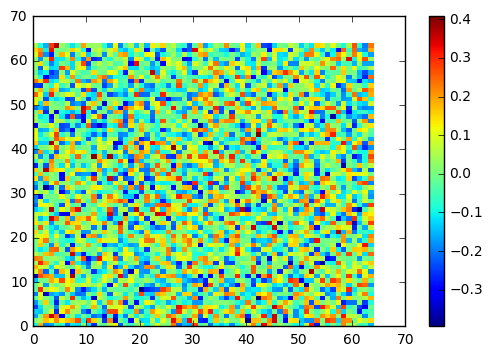

(64, 64)
('element portion close to zero: (<0.0001): ', 0.011962890625)


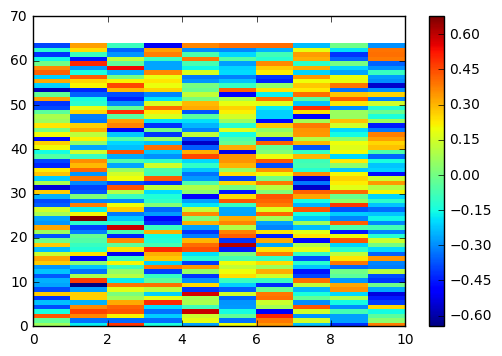

(64, 10)
('element portion close to zero: (<0.0001): ', 0.0)


In [101]:
plt.figure()
plt.pcolormesh(compareMap_tanh)
# plt.imshow(compareMap, cmap = 'hot', interpolation = 'none', extent=[0,9,0,9], origin='lower')
plt.colorbar()
plt.show()
# print model0.to_json()
print compareMap_tanh

plt.figure()
plt.title("tanh")
plt.ylabel("loss")
plt.xlabel("epochs")

ls, = plt.plot(his_tanh.history['loss'], 'b-', label = 'training loss')
vls, = plt.plot(his_tanh.history['val_loss'], 'r-', label = 'validation loss')
plt.legend(handles=[ls, vls])
plt.show()
for wi in model_tanh.get_weights():
    print wi.shape
# print model0.get_weights()[1]
for wi in model_tanh.get_weights():
    # print wi.shape
    if (len(wi.shape) <= 1):
        continue;
    plt.figure()
    plt.pcolormesh(wi)
    plt.colorbar()
    plt.show()
    print wi.shape
    r, c = wi.shape
    zero_cnt = 0.0
    for row in wi:
        for ele in row:
            if abs(ele) < 0.0001:
                zero_cnt += 1
    print ("element portion close to zero: (<0.0001): ", zero_cnt/(r*c))

## Visualization of best network model weights

In [108]:
from keras.utils.visualize_util import plot
plot(modell1_00001, to_file='/Users/Alex/Dropbox/CNS187/model.png', show_shapes= True)